In [1]:
!nvidia-smi

Fri Mar  1 12:20:45 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.147.05   Driver Version: 525.147.05   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:2D:00.0  On |                  N/A |
|  0%   44C    P8    17W / 170W |    335MiB / 12288MiB |     13%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
os.getcwd()

'/home/bunny/projects/IConNet/notebooks'

In [4]:
os.chdir('..')

In [5]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import sys
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [6]:
import glob
import numpy as np
from tqdm import tqdm
import itertools
import matplotlib.pyplot as plt
import pandas as pd

# Scikit learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [11]:
data_dir = '../data/crema_d/preprocessing/'

In [13]:
sr = 16000

data_x = np.load(f'{data_dir}crema_d.audio16k.npy', allow_pickle=True)
data_y = np.load(f'{data_dir}crema_d.label6.npy', allow_pickle=True)
print(data_x.shape)
print(data_y.shape)
np.unique(data_y)

(7442,)
(7442,)


array(['ang', 'dis', 'fea', 'hap', 'neu', 'sad'], dtype=object)

In [14]:
labels = ['ang', 'neu', 'sad', 'hap']

def label_filter(label):
    return label in labels

def label_to_index(label):
    return labels.index(label)
    
filtered_idx = [label_filter(idx) for idx in data_y]
data_x = data_x[filtered_idx]
data_y = [label_to_index(idx) for idx in data_y[filtered_idx]]
print(data_x.shape)

(4900,)


In [15]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    data_x, data_y, test_size=0.2, 
    random_state=42, stratify=data_y)
print("Train: %i" % len(x_train))
print("Test: %i" % len(x_test))

Train: 3920
Test: 980


In [16]:
train_set = list(zip(x_train, y_train))
test_set = list(zip(x_test, y_test))

In [17]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(
        batch, batch_first=True, padding_value=0.).permute(0, 2, 1)
    return batch

def collate_fn(batch, max_duration_in_second=3, sample_rate=sr):
    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, label in batch:
        if max_duration_in_second is not None:
            waveform = np.array(waveform, dtype=float).squeeze()
            length = len(waveform)
            max_length = sample_rate * max_duration_in_second
            offset = max(0, (length - max_length) // 2)
            waveform = waveform[offset: length-offset]
        tensors += [torch.tensor(waveform, dtype=torch.float32)[None,:]]
        targets += [torch.tensor(label, dtype=torch.long)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)
    return tensors, targets

batch_size = 16

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory, 
    drop_last=True
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory
)

In [37]:
from IConNet.nn.model import M13

In [19]:
from omegaconf import OmegaConf as ocf

In [20]:
import traceback

In [21]:
model_config_path = 'config/model/m13ser.yaml'
model_config = ocf.load(model_config_path)
model_config

{'name': 'M13', 'description': 'FirConv with fftconv', 'fe': {'n_block': 2, 'n_channel': [198, 30], 'kernel_size': [511, 127], 'stride': [2, 4], 'window_k': [5, 9], 'mel_resolution': 3, 'residual_connection_type': 'stack', 'pooling': 'mean', 'filter_type': 'firwin', 'conv_mode': 'fftconv', 'norm_type': 'LocalResponseNorm'}, 'cls': {'n_block': 2, 'n_hidden_dim': [512, 512], 'norm_type': 'LayerNorm'}}

In [38]:
model = M13(config=model_config,
           n_input=1, n_output=len(labels))
model

M13(
  (fe_blocks): FeBlocks(
    (blocks): ModuleList(
      (0-1): 2 x FrontEndBlock(
        (block): ModuleDict(
          (layer): FirConvLayer(
            (conv_layer): ResidualConv1d(
              (pad_layer): PadForConv()
              (stride_layer): DownsampleLayer(
                (pad_right): PadForConv()
              )
              (norm_layer): CustomNormLayer(
                (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
              )
              (act): NLReLU()
            )
          )
          (downsample): ResidualConv1d(
            (pad_layer): PadForConv()
            (stride_layer): DownsampleLayer(
              (pad_right): PadForConv()
            )
            (norm_layer): CustomNormLayer(
              (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
            )
            (act): NLReLU()
          )
        )
      )
    )
  )
  (cls_head): Classifier(
    (blocks): ModuleList(
      (0): Sequential(
        (norm):

In [39]:
n_epoch = 10
train_losses = []
test_accuracy = []
optimizer = optim.RAdam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.1,
    steps_per_epoch=len(train_loader), epochs=n_epoch)

In [40]:
train_loader_length = len(train_loader.dataset)
test_loader_length = len(test_loader.dataset)

def train(model, epoch, log_interval, 
          train_losses=train_losses):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        try:
            _mem_before = torch.cuda.memory_allocated()
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            del data
            gc.collect()
            torch.cuda.empty_cache()
            loss = F.cross_entropy(output.squeeze(), target)
            _mem_during = torch.cuda.memory_allocated()
            del target
            gc.collect()
            torch.cuda.empty_cache()
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad.clip_grad_norm_(
                model.parameters(), 1.0)
            optimizer.step()
            _mem_after = torch.cuda.memory_allocated()
            # print training stats
            if batch_idx % log_interval == 0:
                print(f"Train Epoch: {epoch} [{batch_idx * batch_size}/{train_loader_length} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")
                print(f'Mem before-during-after: {_mem_before} {_mem_during} {_mem_after}')
            # update progress bar
            pbar.update(pbar_update)
            # record loss
            train_losses.append(loss.item())
        except Exception as e:
            print(f'data: {data.shape} => output: {output.shape} | target: {target.shape}')
            traceback.print_exc()

@torch.no_grad
def test(model, epoch, test_loader=test_loader, device=device):
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    acc = correct / test_loader_length
    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{total} ({100. * acc:.0f}%)\n")
    return acc

In [41]:
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        scheduler.step()

  0%|                                                                     | 0.0032679738562091504/10 [00:00<20:37, 123.75s/it]

Train Epoch: 1 [0/3920 (0%)]	Loss: 1.505109
Mem before-during-after: 43219968 3776589312 70591488


  1%|▉                                                                       | 0.1339869281045752/10 [00:16<21:59, 133.69s/it]

Train Epoch: 1 [640/3920 (16%)]	Loss: 1.325223
Mem before-during-after: 70171648 4067724288 70171648


  3%|█▉                                                                     | 0.26470588235294074/10 [00:32<21:59, 135.49s/it]

Train Epoch: 1 [1280/3920 (33%)]	Loss: 1.521689
Mem before-during-after: 69352448 4066737152 70171648


  4%|██▊                                                                     | 0.3954248366013063/10 [00:48<21:38, 135.22s/it]

Train Epoch: 1 [1920/3920 (49%)]	Loss: 1.376062
Mem before-during-after: 70171648 4067724288 70171648


  5%|███▊                                                                    | 0.5261437908496719/10 [01:04<21:17, 134.82s/it]

Train Epoch: 1 [2560/3920 (65%)]	Loss: 1.429396
Mem before-during-after: 69295104 4065713152 70205952


  7%|████▋                                                                   | 0.6568627450980374/10 [01:20<22:15, 142.96s/it]

Train Epoch: 1 [3200/3920 (82%)]	Loss: 1.301611
Mem before-during-after: 69527040 4067819008 69614592


  8%|█████▋                                                                   | 0.787581699346403/10 [01:35<20:48, 135.48s/it]

Train Epoch: 1 [3840/3920 (98%)]	Loss: 1.177958
Mem before-during-after: 71025152 4067724288 71025152


 10%|███████▍                                                                  | 0.999999999999997/10 [01:52<10:58, 73.21s/it]


Test Epoch: 1	Accuracy: 384/976 (39%)



 10%|███████▎                                                                 | 1.0032679738562063/10 [01:52<13:08, 87.67s/it]

Train Epoch: 2 [0/3920 (0%)]	Loss: 1.555450
Mem before-during-after: 69282816 4066397696 69352448


 11%|████████▏                                                               | 1.1339869281045718/10 [02:08<19:54, 134.75s/it]

Train Epoch: 2 [640/3920 (16%)]	Loss: 1.101338
Mem before-during-after: 70171648 4067646464 70171648


 13%|█████████                                                               | 1.2647058823529373/10 [02:24<20:45, 142.64s/it]

Train Epoch: 2 [1280/3920 (33%)]	Loss: 0.883514
Mem before-during-after: 69852160 4068445696 71025152


 14%|██████████▏                                                              | 1.395424836601303/10 [02:40<19:24, 135.37s/it]

Train Epoch: 2 [1920/3920 (49%)]	Loss: 0.639390
Mem before-during-after: 70171648 4067646464 70171648


 15%|██████████▉                                                             | 1.5261437908496684/10 [02:56<19:05, 135.23s/it]

Train Epoch: 2 [2560/3920 (65%)]	Loss: 1.049051
Mem before-during-after: 70171648 4067724288 70171648


 17%|████████████                                                             | 1.656862745098034/10 [03:12<18:44, 134.84s/it]

Train Epoch: 2 [3200/3920 (82%)]	Loss: 0.875028
Mem before-during-after: 70171648 4067724288 70171648


 18%|████████████▊                                                           | 1.7875816993463995/10 [03:28<18:27, 134.81s/it]

Train Epoch: 2 [3840/3920 (98%)]	Loss: 1.143783
Mem before-during-after: 71025152 4067724288 71025152


 20%|██████████████▌                                                          | 1.9999999999999936/10 [03:44<09:57, 74.71s/it]


Test Epoch: 2	Accuracy: 504/976 (51%)



 20%|██████████████▊                                                           | 2.003267973856203/10 [03:44<12:00, 90.11s/it]

Train Epoch: 3 [0/3920 (0%)]	Loss: 0.871874
Mem before-during-after: 69282816 4066397696 69352448


 21%|███████████████▎                                                        | 2.1339869281045685/10 [04:00<17:40, 134.78s/it]

Train Epoch: 3 [640/3920 (16%)]	Loss: 1.128768
Mem before-during-after: 70205952 4066737152 70171648


 23%|████████████████▌                                                        | 2.264705882352934/10 [04:16<17:29, 135.64s/it]

Train Epoch: 3 [1280/3920 (33%)]	Loss: 0.932380
Mem before-during-after: 70205952 4066180096 69614592


 24%|█████████████████▏                                                      | 2.3954248366012996/10 [04:32<17:01, 134.26s/it]

Train Epoch: 3 [1920/3920 (49%)]	Loss: 0.982928
Mem before-during-after: 70171648 4067724288 70171648


 25%|██████████████████▍                                                      | 2.526143790849665/10 [04:47<16:46, 134.64s/it]

Train Epoch: 3 [2560/3920 (65%)]	Loss: 1.138413
Mem before-during-after: 71025152 4067724288 71025152


 27%|███████████████████▏                                                    | 2.6568627450980307/10 [05:03<16:29, 134.72s/it]

Train Epoch: 3 [3200/3920 (82%)]	Loss: 1.136935
Mem before-during-after: 69527040 4067089408 70468096


 28%|████████████████████▎                                                    | 2.787581699346396/10 [05:19<16:30, 137.27s/it]

Train Epoch: 3 [3840/3920 (98%)]	Loss: 0.749392
Mem before-during-after: 70171648 4067646464 70171648


 30%|█████████████████████▉                                                   | 2.9999999999999902/10 [05:35<08:25, 72.16s/it]


Test Epoch: 3	Accuracy: 524/976 (53%)



 30%|█████████████████████▉                                                   | 3.0032679738561994/10 [05:36<10:06, 86.62s/it]

Train Epoch: 4 [0/3920 (0%)]	Loss: 1.233824
Mem before-during-after: 69282816 4066460160 69289984


 31%|██████████████████████▉                                                  | 3.133986928104565/10 [05:52<15:22, 134.35s/it]

Train Epoch: 4 [640/3920 (16%)]	Loss: 1.509361
Mem before-during-after: 69614592 4065156096 70205952


 33%|███████████████████████▌                                                | 3.2647058823529305/10 [06:07<15:02, 133.99s/it]

Train Epoch: 4 [1280/3920 (33%)]	Loss: 0.908169
Mem before-during-after: 71025152 4067724288 71025152


 34%|████████████████████████▊                                                | 3.395424836601296/10 [06:23<14:40, 133.38s/it]

Train Epoch: 4 [1920/3920 (49%)]	Loss: 0.811194
Mem before-during-after: 70171648 4067724288 70171648


 35%|█████████████████████████▍                                              | 3.5261437908496616/10 [06:39<14:28, 134.12s/it]

Train Epoch: 4 [2560/3920 (65%)]	Loss: 1.163499
Mem before-during-after: 70171648 4067724288 70171648


 37%|██████████████████████████▋                                              | 3.656862745098027/10 [06:55<14:10, 134.12s/it]

Train Epoch: 4 [3200/3920 (82%)]	Loss: 0.908768
Mem before-during-after: 70171648 4067724288 70171648


 38%|███████████████████████████▎                                            | 3.7875816993463927/10 [07:11<13:52, 134.00s/it]

Train Epoch: 4 [3840/3920 (98%)]	Loss: 0.744863
Mem before-during-after: 71025152 4067724288 71025152


 40%|█████████████████████████████▏                                           | 3.9999999999999867/10 [07:27<07:19, 73.20s/it]


Test Epoch: 4	Accuracy: 541/976 (55%)



 40%|█████████████████████████████▌                                            | 4.003267973856196/10 [07:27<08:46, 87.83s/it]

Train Epoch: 5 [0/3920 (0%)]	Loss: 1.142534
Mem before-during-after: 69282816 4066460160 69289984


 41%|██████████████████████████████▏                                          | 4.133986928104561/10 [07:43<13:08, 134.42s/it]

Train Epoch: 5 [640/3920 (16%)]	Loss: 1.204409
Mem before-during-after: 69614592 4066278912 69614592


 43%|███████████████████████████████▏                                         | 4.264705882352927/10 [07:59<12:50, 134.34s/it]

Train Epoch: 5 [1280/3920 (33%)]	Loss: 1.163582
Mem before-during-after: 69614592 4066270208 70205952


 44%|███████████████████████████████▋                                        | 4.3954248366012925/10 [08:15<12:32, 134.27s/it]

Train Epoch: 5 [1920/3920 (49%)]	Loss: 0.795362
Mem before-during-after: 71025152 4067724288 71025152


 45%|█████████████████████████████████                                        | 4.526143790849658/10 [08:30<12:12, 133.81s/it]

Train Epoch: 5 [2560/3920 (65%)]	Loss: 1.067167
Mem before-during-after: 70171648 4067646464 70171648


 47%|█████████████████████████████████▉                                       | 4.656862745098024/10 [08:46<12:00, 134.92s/it]

Train Epoch: 5 [3200/3920 (82%)]	Loss: 0.882463
Mem before-during-after: 69642240 4066835968 70199296


 48%|██████████████████████████████████▉                                      | 4.787581699346389/10 [09:02<11:47, 135.72s/it]

Train Epoch: 5 [3840/3920 (98%)]	Loss: 0.940668
Mem before-during-after: 69289984 4066270208 70205952


 50%|████████████████████████████████████▉                                     | 4.999999999999983/10 [09:18<06:15, 75.16s/it]


Test Epoch: 5	Accuracy: 472/976 (48%)



 50%|█████████████████████████████████████                                     | 5.003267973856192/10 [09:19<07:25, 89.23s/it]

Train Epoch: 6 [0/3920 (0%)]	Loss: 1.229644
Mem before-during-after: 69282816 4066460160 69289984


 51%|█████████████████████████████████████▍                                   | 5.133986928104558/10 [09:35<11:15, 138.89s/it]

Train Epoch: 6 [640/3920 (16%)]	Loss: 1.091787
Mem before-during-after: 70171648 4067724288 70171648


 53%|██████████████████████████████████████▍                                  | 5.264705882352923/10 [09:51<10:39, 135.10s/it]

Train Epoch: 6 [1280/3920 (33%)]	Loss: 0.934455
Mem before-during-after: 71025152 4067724288 71025152


 54%|███████████████████████████████████████▍                                 | 5.395424836601289/10 [10:07<10:17, 134.17s/it]

Train Epoch: 6 [1920/3920 (49%)]	Loss: 0.949597
Mem before-during-after: 70171648 4067646464 70171648


 55%|███████████████████████████████████████▊                                | 5.5261437908496545/10 [10:23<10:16, 137.72s/it]

Train Epoch: 6 [2560/3920 (65%)]	Loss: 1.719945
Mem before-during-after: 70171648 4067724288 70171648


 57%|█████████████████████████████████████████▊                                | 5.65686274509802/10 [10:39<09:43, 134.34s/it]

Train Epoch: 6 [3200/3920 (82%)]	Loss: 0.999579
Mem before-during-after: 69532672 4066827264 70205952


 58%|█████████████████████████████████████████▋                              | 5.7875816993463856/10 [10:55<09:51, 140.53s/it]

Train Epoch: 6 [3840/3920 (98%)]	Loss: 1.271682
Mem before-during-after: 69352448 4065623040 69614592


 60%|████████████████████████████████████████████▉                              | 5.99999999999998/10 [11:11<04:50, 72.72s/it]


Test Epoch: 6	Accuracy: 489/976 (50%)



 60%|████████████████████████████████████████████▍                             | 6.003267973856189/10 [11:11<05:48, 87.31s/it]

Train Epoch: 7 [0/3920 (0%)]	Loss: 0.904656
Mem before-during-after: 69282816 4066460160 69289984


 61%|████████████████████████████████████████████▊                            | 6.133986928104554/10 [11:27<08:39, 134.41s/it]

Train Epoch: 7 [640/3920 (16%)]	Loss: 1.085342
Mem before-during-after: 69614592 4066737152 70171648


 63%|██████████████████████████████████████████████▎                           | 6.26470588235292/10 [11:43<08:24, 134.97s/it]

Train Epoch: 7 [1280/3920 (33%)]	Loss: 1.092114
Mem before-during-after: 70171648 4067724288 70171648


 64%|██████████████████████████████████████████████▋                          | 6.395424836601285/10 [11:59<08:03, 134.00s/it]

Train Epoch: 7 [1920/3920 (49%)]	Loss: 0.607443
Mem before-during-after: 69352448 4066180096 69614592


 65%|███████████████████████████████████████████████▋                         | 6.526143790849651/10 [12:15<07:47, 134.57s/it]

Train Epoch: 7 [2560/3920 (65%)]	Loss: 1.122853
Mem before-during-after: 71025152 4067724288 71025152


 67%|███████████████████████████████████████████████▉                        | 6.6568627450980165/10 [12:30<07:30, 134.63s/it]

Train Epoch: 7 [3200/3920 (82%)]	Loss: 0.989441
Mem before-during-after: 70171648 4067646464 70171648


 68%|█████████████████████████████████████████████████▌                       | 6.787581699346382/10 [12:46<07:09, 133.58s/it]

Train Epoch: 7 [3840/3920 (98%)]	Loss: 0.847810
Mem before-during-after: 70171648 4067724288 70171648


 70%|███████████████████████████████████████████████████▊                      | 6.999999999999976/10 [13:02<03:40, 73.36s/it]


Test Epoch: 7	Accuracy: 560/976 (57%)



 70%|███████████████████████████████████████████████████▊                      | 7.003267973856185/10 [13:03<04:21, 87.14s/it]

Train Epoch: 8 [0/3920 (0%)]	Loss: 0.853570
Mem before-during-after: 69282816 3944462848 69479936


 71%|████████████████████████████████████████████████████                     | 7.133986928104551/10 [13:19<06:30, 136.17s/it]

Train Epoch: 8 [640/3920 (16%)]	Loss: 0.790957
Mem before-during-after: 70171648 4067724288 70171648


 73%|█████████████████████████████████████████████████████                    | 7.264705882352916/10 [13:35<06:10, 135.37s/it]

Train Epoch: 8 [1280/3920 (33%)]	Loss: 0.855323
Mem before-during-after: 70171648 4036533248 69289984


 74%|█████████████████████████████████████████████████████▉                   | 7.395424836601282/10 [13:51<05:50, 134.50s/it]

Train Epoch: 8 [1920/3920 (49%)]	Loss: 0.937904
Mem before-during-after: 70171648 3687686144 69850624


 75%|██████████████████████████████████████████████████████▉                  | 7.526143790849647/10 [14:06<05:34, 135.24s/it]

Train Epoch: 8 [2560/3920 (65%)]	Loss: 0.975068
Mem before-during-after: 70171648 4067646464 70171648


 77%|███████████████████████████████████████████████████████▉                 | 7.656862745098013/10 [14:22<05:15, 134.53s/it]

Train Epoch: 8 [3200/3920 (82%)]	Loss: 0.774798
Mem before-during-after: 70171648 4067646464 70171648


 78%|████████████████████████████████████████████████████████                | 7.7875816993463784/10 [14:38<04:56, 133.94s/it]

Train Epoch: 8 [3840/3920 (98%)]	Loss: 0.754678
Mem before-during-after: 71025152 4067724288 71025152


 80%|██████████████████████████████████████████████████████████▍              | 7.9999999999999725/10 [14:55<02:30, 75.16s/it]


Test Epoch: 8	Accuracy: 521/976 (53%)



 80%|███████████████████████████████████████████████████████████▏              | 8.003267973856182/10 [14:55<02:57, 89.14s/it]

Train Epoch: 9 [0/3920 (0%)]	Loss: 0.590410
Mem before-during-after: 69282816 4066460160 69289984


 81%|███████████████████████████████████████████████████████████▍             | 8.133986928104548/10 [15:11<04:15, 136.95s/it]

Train Epoch: 9 [640/3920 (16%)]	Loss: 1.277283
Mem before-during-after: 70171648 4065111040 69352448


 83%|████████████████████████████████████████████████████████████▎            | 8.264705882352914/10 [15:28<03:56, 136.11s/it]

Train Epoch: 9 [1280/3920 (33%)]	Loss: 0.987435
Mem before-during-after: 69614592 4066835968 71025152


 84%|██████████████████████████████████████████████████████████████▏           | 8.39542483660128/10 [15:44<03:38, 136.22s/it]

Train Epoch: 9 [1920/3920 (49%)]	Loss: 0.988081
Mem before-during-after: 70171648 4067724288 70171648


 85%|██████████████████████████████████████████████████████████████▏          | 8.526143790849645/10 [16:00<03:21, 136.58s/it]

Train Epoch: 9 [2560/3920 (65%)]	Loss: 1.311064
Mem before-during-after: 70171648 4065111040 69352448


 87%|████████████████████████████████████████████████████████████████          | 8.65686274509801/10 [16:16<03:01, 134.83s/it]

Train Epoch: 9 [3200/3920 (82%)]	Loss: 0.877806
Mem before-during-after: 70171648 3818520064 69289984


 88%|████████████████████████████████████████████████████████████████▏        | 8.787581699346376/10 [16:32<02:44, 135.92s/it]

Train Epoch: 9 [3840/3920 (98%)]	Loss: 0.841845
Mem before-during-after: 70171648 4067646464 70171648


 90%|███████████████████████████████████████████████████████████████████▍       | 8.99999999999997/10 [16:48<01:13, 73.39s/it]


Test Epoch: 9	Accuracy: 539/976 (55%)



 90%|██████████████████████████████████████████████████████████████████▌       | 9.003267973856179/10 [16:48<01:31, 92.17s/it]

Train Epoch: 10 [0/3920 (0%)]	Loss: 1.047375
Mem before-during-after: 69282816 4066397696 69352448


 91%|██████████████████████████████████████████████████████████████████▋      | 9.133986928104544/10 [17:04<01:57, 135.53s/it]

Train Epoch: 10 [640/3920 (16%)]	Loss: 0.976494
Mem before-during-after: 71025152 3777742848 69873664


 93%|████████████████████████████████████████████████████████████████████▌     | 9.26470588235291/10 [17:21<01:40, 136.47s/it]

Train Epoch: 10 [1280/3920 (33%)]	Loss: 1.019553
Mem before-during-after: 71025152 4067724288 71025152


 94%|████████████████████████████████████████████████████████████████████▌    | 9.395424836601276/10 [17:37<01:22, 136.58s/it]

Train Epoch: 10 [1920/3920 (49%)]	Loss: 0.860085
Mem before-during-after: 71025152 4067724288 71025152


 95%|█████████████████████████████████████████████████████████████████████▌   | 9.526143790849641/10 [17:53<01:04, 136.29s/it]

Train Epoch: 10 [2560/3920 (65%)]	Loss: 0.888161
Mem before-during-after: 70171648 4067724288 70171648


 97%|██████████████████████████████████████████████████████████████████████▍  | 9.656862745098007/10 [18:08<00:46, 135.79s/it]

Train Epoch: 10 [3200/3920 (82%)]	Loss: 0.767944
Mem before-during-after: 71025152 4067724288 71025152


 98%|███████████████████████████████████████████████████████████████████████▍ | 9.787581699346372/10 [18:24<00:28, 135.35s/it]

Train Epoch: 10 [3840/3920 (98%)]	Loss: 0.753896
Mem before-during-after: 71025152 4067724288 71025152


100%|████████████████████████████████████████████████████████████████████████▉| 9.999999999999966/10 [18:41<00:00, 112.13s/it]


Test Epoch: 10	Accuracy: 562/976 (57%)



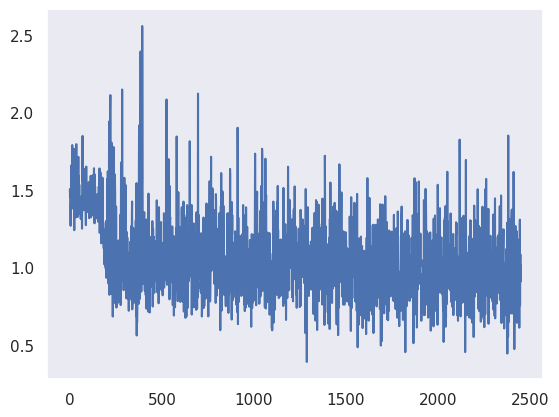

In [42]:
plt.plot(train_losses)

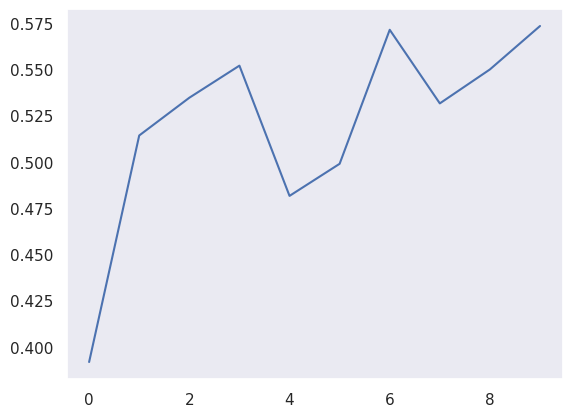

In [43]:
plt.plot(test_accuracy)

In [44]:
from torchmetrics.classification import (
    MulticlassAccuracy, MulticlassPrecision, 
    MulticlassRecall, MulticlassF1Score, 
    MulticlassConfusionMatrix,
    MulticlassAUROC
)
from torchmetrics import MetricCollection
from pprint import pprint

@torch.no_grad
def report_metrics(model, labels=labels, 
                   test_loader=test_loader, device=device):
    n = len(labels)
    metrics = MetricCollection({
        'acc_unweighted': MulticlassAccuracy(num_classes=n, average='macro'), 
        'acc_weighted': MulticlassAccuracy(num_classes=n, average='weighted'), 
        
        'f1s_unweighted': MulticlassF1Score(num_classes=n, average='macro'),  
        'f1s_weighted': MulticlassF1Score(num_classes=n, average='weighted'),  

        'acc_weighted': MulticlassAccuracy(num_classes=n, average='weighted'), 
        'uar': MulticlassRecall(num_classes=n, average='macro'), 
        'wap': MulticlassPrecision(num_classes=n, average='weighted'),
        'rocauc': MulticlassAUROC(num_classes=n, average='macro', thresholds=None),    
        'f1s_detail': MulticlassF1Score(num_classes=n, average=None),  
        'acc_detail': MulticlassAccuracy(num_classes=n, average=None), 
        'precision_detail': MulticlassPrecision(num_classes=n, average=None),
        'recall_detail': MulticlassRecall(num_classes=n, average=None), 
        'rocauc_detail': MulticlassAUROC(num_classes=n, average=None, thresholds=None),
    }).to(device)
    confusion_matrix = MulticlassConfusionMatrix(num_classes=n).to(device)
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        
        metrics.update(probs, target)
        confusion_matrix.update(pred, target)
        
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    print(f'Correct: {correct}/{total} ({correct/total:.4f})')
    return metrics, confusion_matrix

In [45]:
metrics, confusion_matrix = report_metrics(
    model, labels=labels, device=device)
pprint(metrics.compute())
confusion_matrix.compute()

Correct: 562/976 (0.5758)
{'acc_detail': tensor([0.6403, 0.4147, 0.5787, 0.6468], device='cuda:0'),
 'acc_unweighted': tensor(0.5702, device='cuda:0'),
 'acc_weighted': tensor(0.5758, device='cuda:0'),
 'f1s_detail': tensor([0.6894, 0.4390, 0.6562, 0.5224], device='cuda:0'),
 'f1s_unweighted': tensor(0.5768, device='cuda:0'),
 'f1s_weighted': tensor(0.5820, device='cuda:0'),
 'precision_detail': tensor([0.7465, 0.4663, 0.7577, 0.4382], device='cuda:0'),
 'recall_detail': tensor([0.6403, 0.4147, 0.5787, 0.6468], device='cuda:0'),
 'rocauc': tensor(0.8396, device='cuda:0'),
 'rocauc_detail': tensor([0.9109, 0.7987, 0.8940, 0.7549], device='cuda:0'),
 'uar': tensor(0.5702, device='cuda:0'),
 'wap': tensor(0.6075, device='cuda:0')}


tensor([[162,   6,   0,  85],
        [  1,  90,  37,  89],
        [  3,  69, 147,  35],
        [ 51,  28,  10, 163]], device='cuda:0')

In [29]:
# metrics, confusion_matrix = report_metrics(
#     model, labels=labels, device=device)
# pprint(metrics.compute())
# confusion_matrix.compute()

Correct: 551/976 (0.5645)
{'acc_detail': tensor([0.4308, 0.5346, 0.6378, 0.6508], device='cuda:0'),
 'acc_unweighted': tensor(0.5635, device='cuda:0'),
 'acc_weighted': tensor(0.5645, device='cuda:0'),
 'f1s_detail': tensor([0.5677, 0.5000, 0.6778, 0.5240], device='cuda:0'),
 'f1s_unweighted': tensor(0.5674, device='cuda:0'),
 'f1s_weighted': tensor(0.5700, device='cuda:0'),
 'precision_detail': tensor([0.8321, 0.4696, 0.7232, 0.4385], device='cuda:0'),
 'recall_detail': tensor([0.4308, 0.5346, 0.6378, 0.6508], device='cuda:0'),
 'rocauc': tensor(0.8364, device='cuda:0'),
 'rocauc_detail': tensor([0.9091, 0.8027, 0.8973, 0.7364], device='cuda:0'),
 'uar': tensor(0.5635, device='cuda:0'),
 'wap': tensor(0.6215, device='cuda:0')}


tensor([[109,  10,   0, 134],
        [  0, 116,  47,  54],
        [  1,  69, 162,  22],
        [ 21,  52,  15, 164]], device='cuda:0')

In [50]:
model_path = '../models_cremad4/cremad_label4_m13ser_lognorm_10epochs.pt' 
torch.save(model.state_dict(), model_path)

Time domain: Filters' shapes vary by frequency bins


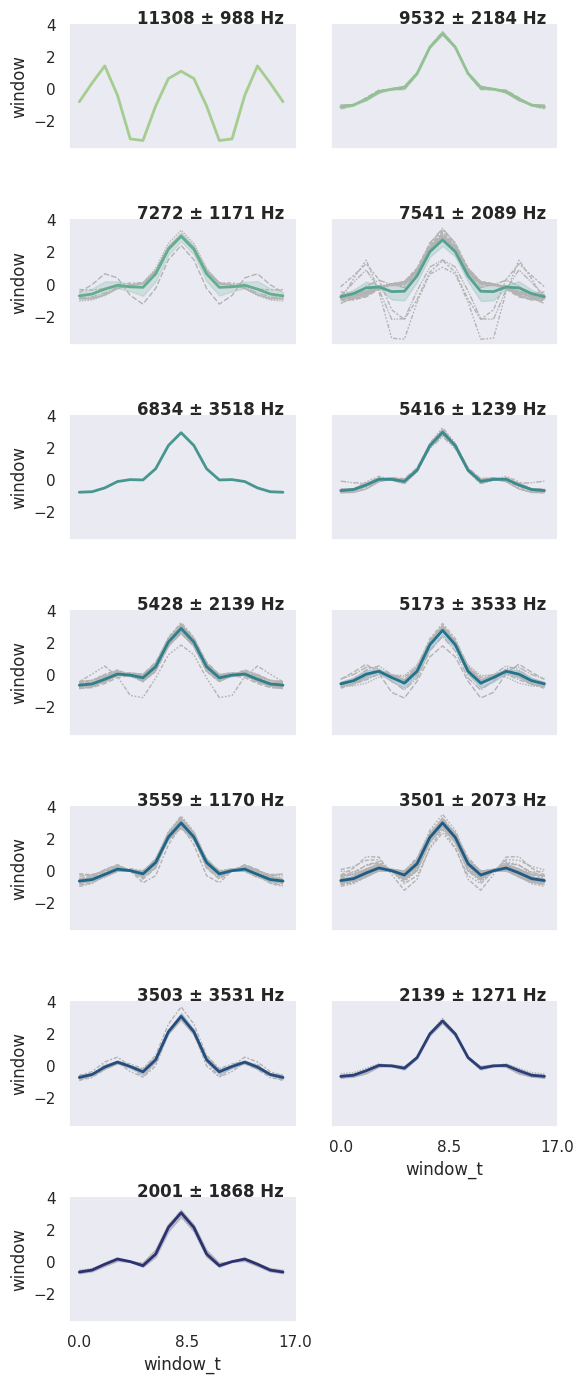

In [47]:
from IConNet.visualizer import visualize_model

layer = model.fe_blocks.blocks[0].block.layer

filtviz = visualize_model.FilterVisualizer(
    lowcut_bands = layer.lowcut_bands, 
    bandwidths = layer.bandwidths,
    window_params = layer.window_params, 
    window_length = 64,
    sample_rate = sr
)
filtviz.visualize_filters(filter_domain='time')

Frequency domain: Filters' shapes vary by frequency bins


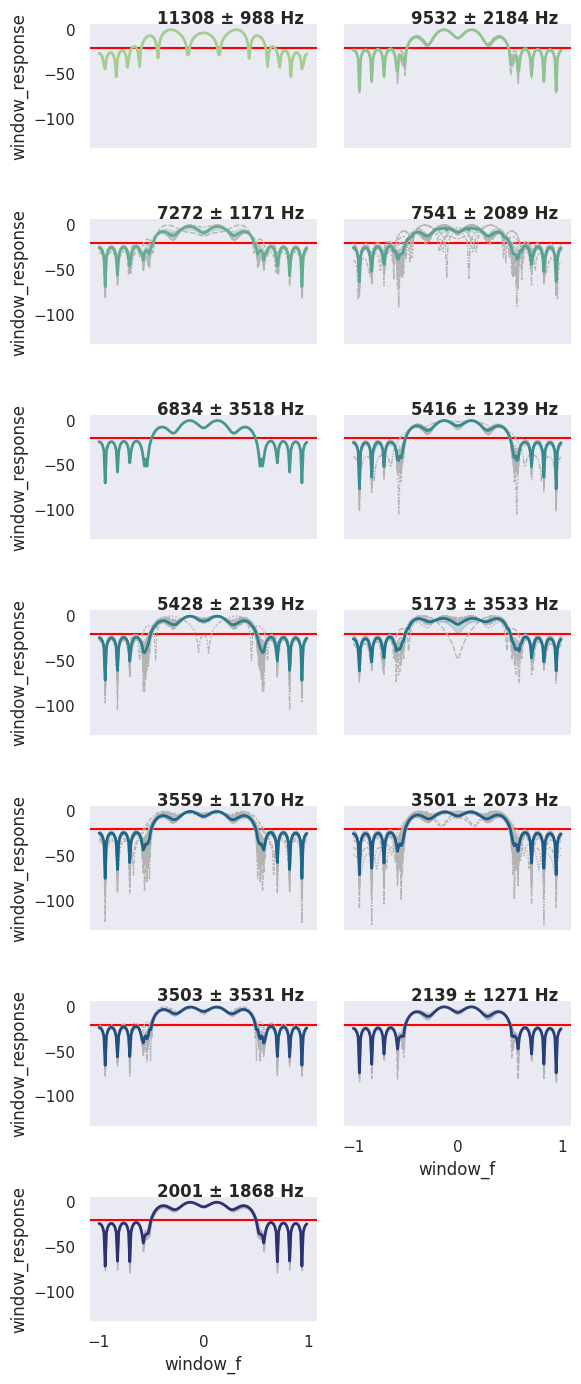

In [48]:
filtviz.visualize_filters(filter_domain='freq')

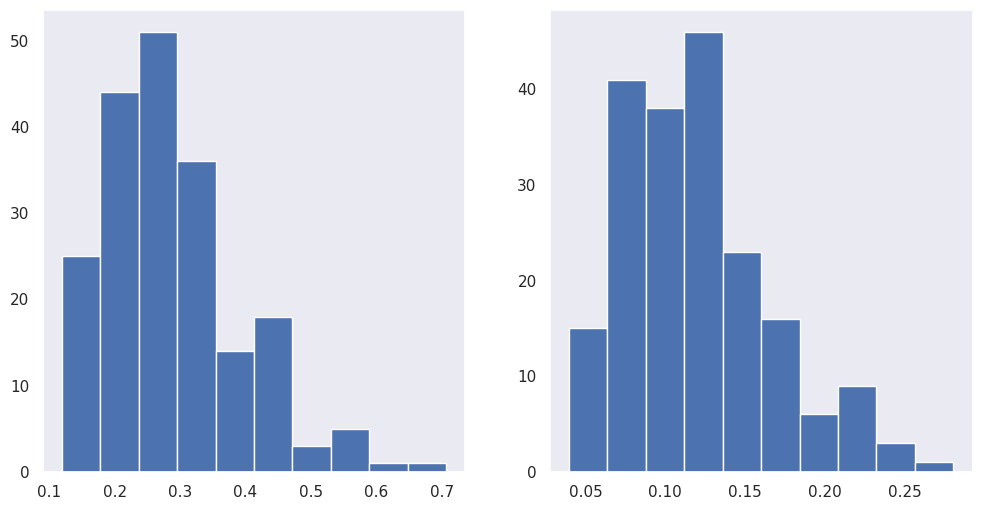

In [49]:
filtviz.visualize_bands()

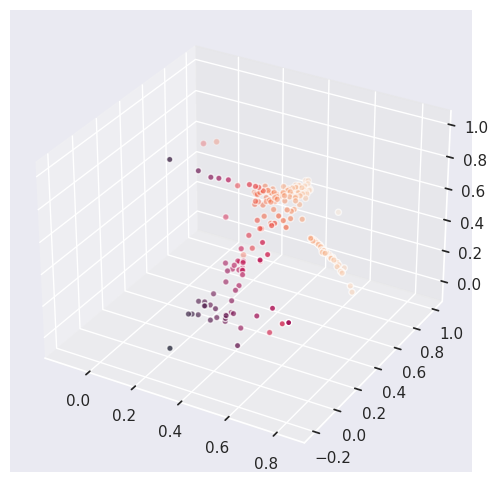

In [35]:
filtviz.visualize_window_params()

In [51]:
n_epoch = 10
n_epoch2 = 50
# train_losses = []
# test_accuracy = []
best_accuracy = test_accuracy[-1]
best_epoch = n_epoch
model_path_prefix = '../models_cremad4/cremad_label4_m13ser_lognorm_best_'

optimizer = optim.RAdam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.01,
    steps_per_epoch=len(train_loader), epochs=n_epoch2)
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
# model.to(device)
with tqdm(total=n_epoch2) as pbar:
    for epoch in range(1+n_epoch, n_epoch2 + n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        if acc > best_accuracy:
            best_accuracy = acc
            best_epoch = epoch
            bmodel_path = f'{model_path_prefix}{epoch}epoch.pt'
            torch.save(model.state_dict(), bmodel_path)
            print(f'saved model: {bmodel_path}')
        scheduler.step()

  0%|                                                                   | 0.0032679738562091504/50 [00:00<2:00:16, 144.34s/it]

Train Epoch: 11 [0/3920 (0%)]	Loss: 0.886838
Mem before-during-after: 65673728 4062851072 69290496


  0%|▏                                                                     | 0.1339869281045752/50 [00:16<1:55:33, 139.04s/it]

Train Epoch: 11 [640/3920 (16%)]	Loss: 0.807375
Mem before-during-after: 69382144 4066836480 71025664


  1%|▎                                                                    | 0.26470588235294074/50 [00:32<1:58:52, 143.41s/it]

Train Epoch: 11 [1280/3920 (33%)]	Loss: 0.781642
Mem before-during-after: 70172160 4067724800 70172160


  1%|▌                                                                     | 0.3954248366013063/50 [00:48<1:52:24, 135.96s/it]

Train Epoch: 11 [1920/3920 (49%)]	Loss: 1.045577
Mem before-during-after: 69972480 4068834816 70172160


  1%|▋                                                                     | 0.5261437908496719/50 [01:04<1:51:37, 135.37s/it]

Train Epoch: 11 [2560/3920 (65%)]	Loss: 1.071631
Mem before-during-after: 70172160 4067724800 70172160


  1%|▉                                                                     | 0.6568627450980374/50 [01:20<1:52:19, 136.58s/it]

Train Epoch: 11 [3200/3920 (82%)]	Loss: 0.915805
Mem before-during-after: 69480448 4066737664 70172160


  2%|█                                                                      | 0.787581699346403/50 [01:36<1:51:05, 135.43s/it]

Train Epoch: 11 [3840/3920 (98%)]	Loss: 0.534493
Mem before-during-after: 71025664 4067724800 71025664


  2%|█▍                                                                      | 0.999999999999997/50 [01:53<1:02:57, 77.09s/it]


Test Epoch: 11	Accuracy: 576/976 (59%)

saved model: ../models_cremad4/cremad_label4_m13ser_lognorm_best_11epoch.pt


  2%|█▍                                                                     | 1.0032679738562063/50 [01:53<1:14:31, 91.26s/it]

Train Epoch: 12 [0/3920 (0%)]	Loss: 0.716321
Mem before-during-after: 69283328 4066398208 69352960


  2%|█▌                                                                    | 1.1339869281045718/50 [02:09<1:51:05, 136.41s/it]

Train Epoch: 12 [640/3920 (16%)]	Loss: 0.670354
Mem before-during-after: 70172160 4067089920 69615104


  3%|█▊                                                                    | 1.2647058823529373/50 [02:25<1:49:54, 135.31s/it]

Train Epoch: 12 [1280/3920 (33%)]	Loss: 0.843423
Mem before-during-after: 70172160 4067089920 69615104


  3%|█▉                                                                     | 1.395424836601303/50 [02:42<1:51:18, 137.40s/it]

Train Epoch: 12 [1920/3920 (49%)]	Loss: 0.949692
Mem before-during-after: 71025664 4067724800 71025664


  3%|██▏                                                                   | 1.5261437908496684/50 [02:58<1:49:59, 136.15s/it]

Train Epoch: 12 [2560/3920 (65%)]	Loss: 0.802387
Mem before-during-after: 71025664 4067724800 71025664


  3%|██▎                                                                    | 1.656862745098034/50 [03:13<1:49:30, 135.92s/it]

Train Epoch: 12 [3200/3920 (82%)]	Loss: 0.852192
Mem before-during-after: 69382144 4066827776 70206464


  4%|██▌                                                                   | 1.7875816993463995/50 [03:30<1:50:05, 137.02s/it]

Train Epoch: 12 [3840/3920 (98%)]	Loss: 0.811859
Mem before-during-after: 70172160 4067724800 70172160


  4%|██▊                                                                    | 1.9999999999999936/50 [03:46<1:01:06, 76.38s/it]


Test Epoch: 12	Accuracy: 597/976 (61%)

saved model: ../models_cremad4/cremad_label4_m13ser_lognorm_best_12epoch.pt


  4%|██▉                                                                     | 2.003267973856203/50 [03:47<1:12:41, 90.86s/it]

Train Epoch: 13 [0/3920 (0%)]	Loss: 0.715856
Mem before-during-after: 69283328 4066398208 69352960


  4%|██▉                                                                   | 2.1339869281045685/50 [04:03<1:48:56, 136.56s/it]

Train Epoch: 13 [640/3920 (16%)]	Loss: 0.998174
Mem before-during-after: 70172160 4067724800 70172160


  5%|███▏                                                                   | 2.264705882352934/50 [04:19<1:48:39, 136.58s/it]

Train Epoch: 13 [1280/3920 (33%)]	Loss: 1.048695
Mem before-during-after: 70468608 4065800192 70468608


  5%|███▎                                                                  | 2.3954248366012996/50 [04:35<1:47:47, 135.86s/it]

Train Epoch: 13 [1920/3920 (49%)]	Loss: 0.943055
Mem before-during-after: 70172160 4067646976 70172160


  5%|███▌                                                                   | 2.526143790849665/50 [04:52<1:50:29, 139.65s/it]

Train Epoch: 13 [2560/3920 (65%)]	Loss: 0.956624
Mem before-during-after: 70172160 4067724800 70172160


  5%|███▋                                                                  | 2.6568627450980307/50 [05:08<1:49:45, 139.11s/it]

Train Epoch: 13 [3200/3920 (82%)]	Loss: 0.746782
Mem before-during-after: 70206464 4065879552 70172160


  6%|███▉                                                                   | 2.787581699346396/50 [05:24<1:48:49, 138.29s/it]

Train Epoch: 13 [3840/3920 (98%)]	Loss: 1.099563
Mem before-during-after: 71025664 4067724800 71025664


  6%|████▍                                                                    | 2.9999999999999902/50 [05:41<57:41, 73.64s/it]


Test Epoch: 13	Accuracy: 582/976 (59%)



  6%|████▎                                                                  | 3.0032679738561994/50 [05:41<1:09:07, 88.25s/it]

Train Epoch: 14 [0/3920 (0%)]	Loss: 1.018132
Mem before-during-after: 69283328 4066398208 69352960


  6%|████▍                                                                  | 3.133986928104565/50 [05:57<1:48:30, 138.92s/it]

Train Epoch: 14 [640/3920 (16%)]	Loss: 1.067569
Mem before-during-after: 70172160 4067646976 70172160


  7%|████▌                                                                 | 3.2647058823529305/50 [06:13<1:45:44, 135.76s/it]

Train Epoch: 14 [1280/3920 (33%)]	Loss: 0.974384
Mem before-during-after: 70172160 4067646976 70172160


  7%|████▊                                                                  | 3.395424836601296/50 [06:29<1:46:21, 136.93s/it]

Train Epoch: 14 [1920/3920 (49%)]	Loss: 1.160652
Mem before-during-after: 69615104 4066279424 69615104


  7%|████▉                                                                 | 3.5261437908496616/50 [06:45<1:45:31, 136.23s/it]

Train Epoch: 14 [2560/3920 (65%)]	Loss: 1.038055
Mem before-during-after: 70172160 4067724800 70172160


  7%|█████▏                                                                 | 3.656862745098027/50 [07:01<1:45:17, 136.31s/it]

Train Epoch: 14 [3200/3920 (82%)]	Loss: 0.948906
Mem before-during-after: 71025664 4067724800 71025664


  8%|█████▎                                                                | 3.7875816993463927/50 [07:17<1:44:19, 135.46s/it]

Train Epoch: 14 [3840/3920 (98%)]	Loss: 0.727360
Mem before-during-after: 70172160 4067724800 70172160


  8%|█████▊                                                                   | 3.9999999999999867/50 [07:34<56:11, 73.30s/it]


Test Epoch: 14	Accuracy: 587/976 (60%)



  8%|█████▊                                                                  | 4.003267973856196/50 [07:34<1:07:30, 88.07s/it]

Train Epoch: 15 [0/3920 (0%)]	Loss: 1.068131
Mem before-during-after: 69283328 4066398208 69352960


  8%|█████▊                                                                 | 4.133986928104561/50 [07:50<1:43:11, 134.98s/it]

Train Epoch: 15 [640/3920 (16%)]	Loss: 0.951077
Mem before-during-after: 70468608 4066914304 71025664


  9%|██████                                                                 | 4.264705882352927/50 [08:06<1:42:38, 134.66s/it]

Train Epoch: 15 [1280/3920 (33%)]	Loss: 0.601589
Mem before-during-after: 70172160 3977507840 69290496


  9%|██████▏                                                               | 4.3954248366012925/50 [08:22<1:43:23, 136.02s/it]

Train Epoch: 15 [1920/3920 (49%)]	Loss: 0.992969
Mem before-during-after: 70172160 4067724800 70172160


  9%|██████▍                                                                | 4.526143790849658/50 [08:38<1:41:49, 134.35s/it]

Train Epoch: 15 [2560/3920 (65%)]	Loss: 1.032594
Mem before-during-after: 70172160 4067724800 70172160


  9%|██████▌                                                                | 4.656862745098024/50 [08:54<1:42:18, 135.39s/it]

Train Epoch: 15 [3200/3920 (82%)]	Loss: 0.766105
Mem before-during-after: 71025664 4067724800 71025664


 10%|██████▊                                                                | 4.787581699346389/50 [09:10<1:42:23, 135.89s/it]

Train Epoch: 15 [3840/3920 (98%)]	Loss: 0.952747
Mem before-during-after: 70172160 4066737664 70172160


 10%|███████▍                                                                  | 4.999999999999983/50 [09:27<55:39, 74.21s/it]


Test Epoch: 15	Accuracy: 585/976 (60%)



 10%|███████▏                                                                | 5.003267973856192/50 [09:27<1:06:49, 89.10s/it]

Train Epoch: 16 [0/3920 (0%)]	Loss: 0.858584
Mem before-during-after: 69283328 4066398208 69352960


 10%|███████▎                                                               | 5.133986928104558/50 [09:43<1:41:33, 135.81s/it]

Train Epoch: 16 [640/3920 (16%)]	Loss: 1.197716
Mem before-during-after: 70172160 4067724800 70172160


 11%|███████▍                                                               | 5.264705882352923/50 [09:59<1:40:42, 135.06s/it]

Train Epoch: 16 [1280/3920 (33%)]	Loss: 0.669193
Mem before-during-after: 70172160 4067724800 70172160


 11%|███████▋                                                               | 5.395424836601289/50 [10:15<1:40:22, 135.02s/it]

Train Epoch: 16 [1920/3920 (49%)]	Loss: 0.963371
Mem before-during-after: 70468608 4006046208 69382144


 11%|███████▋                                                              | 5.5261437908496545/50 [10:31<1:40:24, 135.47s/it]

Train Epoch: 16 [2560/3920 (65%)]	Loss: 0.713232
Mem before-during-after: 70172160 4067724800 70172160


 11%|████████▏                                                               | 5.65686274509802/50 [10:47<1:39:57, 135.26s/it]

Train Epoch: 16 [3200/3920 (82%)]	Loss: 1.146007
Mem before-during-after: 71025664 3976729088 69480448


 12%|████████                                                              | 5.7875816993463856/50 [11:03<1:40:47, 136.78s/it]

Train Epoch: 16 [3840/3920 (98%)]	Loss: 0.701491
Mem before-during-after: 70172160 4038882304 69533184


 12%|████████▉                                                                  | 5.99999999999998/50 [11:19<54:00, 73.65s/it]


Test Epoch: 16	Accuracy: 588/976 (60%)



 12%|████████▋                                                               | 6.003267973856189/50 [11:20<1:04:48, 88.38s/it]

Train Epoch: 17 [0/3920 (0%)]	Loss: 0.802495
Mem before-during-after: 69283328 4066460672 69290496


 12%|████████▋                                                              | 6.133986928104554/50 [11:36<1:38:45, 135.08s/it]

Train Epoch: 17 [640/3920 (16%)]	Loss: 0.942574
Mem before-during-after: 70172160 4067724800 70172160


 13%|█████████                                                               | 6.26470588235292/50 [11:52<1:38:22, 134.95s/it]

Train Epoch: 17 [1280/3920 (33%)]	Loss: 0.909862
Mem before-during-after: 71025664 4067724800 71025664


 13%|█████████                                                              | 6.395424836601285/50 [12:08<1:38:30, 135.54s/it]

Train Epoch: 17 [1920/3920 (49%)]	Loss: 1.010501
Mem before-during-after: 69615104 4037252608 69320192


 13%|█████████▎                                                             | 6.526143790849651/50 [12:24<1:37:59, 135.25s/it]

Train Epoch: 17 [2560/3920 (65%)]	Loss: 0.809168
Mem before-during-after: 70172160 4067724800 70172160


 13%|█████████▎                                                            | 6.6568627450980165/50 [12:39<1:37:19, 134.72s/it]

Train Epoch: 17 [3200/3920 (82%)]	Loss: 1.066657
Mem before-during-after: 70172160 3735783936 69972480


 14%|█████████▋                                                             | 6.787581699346382/50 [12:55<1:38:29, 136.76s/it]

Train Epoch: 17 [3840/3920 (98%)]	Loss: 0.879134
Mem before-during-after: 69290496 4064464384 69295616


 14%|██████████▎                                                               | 6.999999999999976/50 [13:12<53:00, 73.97s/it]


Test Epoch: 17	Accuracy: 582/976 (59%)



 14%|██████████                                                              | 7.003267973856185/50 [13:12<1:03:02, 87.98s/it]

Train Epoch: 18 [0/3920 (0%)]	Loss: 0.732660
Mem before-during-after: 69283328 3944463360 69480448


 14%|██████████▏                                                            | 7.133986928104551/50 [13:29<1:37:27, 136.41s/it]

Train Epoch: 18 [640/3920 (16%)]	Loss: 0.945441
Mem before-during-after: 69578752 4069101568 70172160


 15%|██████████▎                                                            | 7.264705882352916/50 [13:44<1:36:22, 135.32s/it]

Train Epoch: 18 [1280/3920 (33%)]	Loss: 0.682748
Mem before-during-after: 71025664 4067724800 71025664


 15%|██████████▌                                                            | 7.395424836601282/50 [14:00<1:36:01, 135.24s/it]

Train Epoch: 18 [1920/3920 (49%)]	Loss: 1.083004
Mem before-during-after: 70172160 4067724800 70172160


 15%|██████████▋                                                            | 7.526143790849647/50 [14:17<1:37:48, 138.17s/it]

Train Epoch: 18 [2560/3920 (65%)]	Loss: 0.931950
Mem before-during-after: 71025664 4067724800 71025664


 15%|██████████▊                                                            | 7.656862745098013/50 [14:33<1:40:13, 142.02s/it]

Train Epoch: 18 [3200/3920 (82%)]	Loss: 1.101714
Mem before-during-after: 70172160 4066532864 69615104


 16%|██████████▉                                                           | 7.7875816993463784/50 [14:49<1:38:15, 139.66s/it]

Train Epoch: 18 [3840/3920 (98%)]	Loss: 0.677198
Mem before-during-after: 70206464 4065918464 69352960


 16%|███████████▋                                                             | 7.9999999999999725/50 [15:06<52:30, 75.00s/it]


Test Epoch: 18	Accuracy: 585/976 (60%)



 16%|███████████▌                                                            | 8.003267973856182/50 [15:06<1:02:35, 89.42s/it]

Train Epoch: 19 [0/3920 (0%)]	Loss: 0.568035
Mem before-during-after: 69283328 4066460672 69290496


 16%|███████████▌                                                           | 8.133986928104548/50 [15:22<1:36:05, 137.72s/it]

Train Epoch: 19 [640/3920 (16%)]	Loss: 1.123967
Mem before-during-after: 70172160 4067724800 70172160


 17%|███████████▋                                                           | 8.264705882352914/50 [15:39<1:34:08, 135.34s/it]

Train Epoch: 19 [1280/3920 (33%)]	Loss: 0.712220
Mem before-during-after: 70172160 4067724800 70172160


 17%|████████████                                                            | 8.39542483660128/50 [15:55<1:34:15, 135.94s/it]

Train Epoch: 19 [1920/3920 (49%)]	Loss: 0.835473
Mem before-during-after: 70172160 4006139904 69290496


 17%|████████████                                                           | 8.526143790849645/50 [16:11<1:34:00, 136.01s/it]

Train Epoch: 19 [2560/3920 (65%)]	Loss: 0.985804
Mem before-during-after: 70172160 4065111552 69352960


 17%|████████████▍                                                           | 8.65686274509801/50 [16:26<1:33:05, 135.09s/it]

Train Epoch: 19 [3200/3920 (82%)]	Loss: 0.860515
Mem before-during-after: 69615104 4066737664 70172160


 18%|████████████▍                                                          | 8.787581699346376/50 [16:42<1:33:26, 136.04s/it]

Train Epoch: 19 [3840/3920 (98%)]	Loss: 0.841999
Mem before-during-after: 69533184 4066827776 70206464


 18%|█████████████▍                                                             | 8.99999999999997/50 [16:59<50:53, 74.47s/it]


Test Epoch: 19	Accuracy: 588/976 (60%)



 18%|████████████▉                                                           | 9.003267973856179/50 [16:59<1:00:43, 88.86s/it]

Train Epoch: 20 [0/3920 (0%)]	Loss: 1.034610
Mem before-during-after: 69283328 4066460672 69290496


 18%|████████████▉                                                          | 9.133986928104544/50 [17:15<1:36:50, 142.18s/it]

Train Epoch: 20 [640/3920 (16%)]	Loss: 0.879100
Mem before-during-after: 70172160 4067724800 70172160


 19%|█████████████▎                                                          | 9.26470588235291/50 [17:31<1:32:22, 136.06s/it]

Train Epoch: 20 [1280/3920 (33%)]	Loss: 0.919860
Mem before-during-after: 70172160 4067724800 70172160


 19%|█████████████▎                                                         | 9.395424836601276/50 [17:47<1:32:06, 136.11s/it]

Train Epoch: 20 [1920/3920 (49%)]	Loss: 0.978843
Mem before-during-after: 71025664 4067724800 71025664


 19%|█████████████▌                                                         | 9.526143790849641/50 [18:03<1:31:29, 135.63s/it]

Train Epoch: 20 [2560/3920 (65%)]	Loss: 0.849797
Mem before-during-after: 71025664 4067724800 71025664


 19%|█████████████▋                                                         | 9.656862745098007/50 [18:19<1:30:46, 135.00s/it]

Train Epoch: 20 [3200/3920 (82%)]	Loss: 0.571823
Mem before-during-after: 70172160 4067724800 70172160


 20%|█████████████▉                                                         | 9.787581699346372/50 [18:35<1:31:11, 136.06s/it]

Train Epoch: 20 [3840/3920 (98%)]	Loss: 0.679160
Mem before-during-after: 70468608 4066914304 71025664


 20%|██████████████▊                                                           | 9.999999999999966/50 [18:52<49:50, 74.75s/it]


Test Epoch: 20	Accuracy: 596/976 (61%)



 20%|██████████████▌                                                          | 10.003267973856175/50 [18:52<59:15, 88.91s/it]

Train Epoch: 21 [0/3920 (0%)]	Loss: 1.093875
Mem before-during-after: 69283328 4066398208 69352960


 20%|██████████████▏                                                       | 10.133986928104541/50 [19:08<1:30:57, 136.89s/it]

Train Epoch: 21 [640/3920 (16%)]	Loss: 0.852085
Mem before-during-after: 70172160 4067724800 70172160


 21%|██████████████▎                                                       | 10.264705882352906/50 [19:25<1:31:06, 137.57s/it]

Train Epoch: 21 [1280/3920 (33%)]	Loss: 0.739297
Mem before-during-after: 70172160 4065930752 69290496


 21%|██████████████▌                                                       | 10.395424836601272/50 [19:41<1:29:24, 135.45s/it]

Train Epoch: 21 [1920/3920 (49%)]	Loss: 0.864366
Mem before-during-after: 70172160 4067089920 69615104


 21%|██████████████▋                                                       | 10.526143790849638/50 [19:56<1:29:11, 135.57s/it]

Train Epoch: 21 [2560/3920 (65%)]	Loss: 1.104775
Mem before-during-after: 70206464 4066180608 69615104


 21%|██████████████▉                                                       | 10.656862745098003/50 [20:12<1:28:52, 135.54s/it]

Train Epoch: 21 [3200/3920 (82%)]	Loss: 1.024931
Mem before-during-after: 69615104 4066914304 70172160


 22%|███████████████                                                       | 10.787581699346369/50 [20:28<1:28:09, 134.89s/it]

Train Epoch: 21 [3840/3920 (98%)]	Loss: 0.824967
Mem before-during-after: 70172160 4067724800 70172160


 22%|████████████████                                                         | 10.999999999999963/50 [20:45<49:13, 75.74s/it]


Test Epoch: 21	Accuracy: 585/976 (60%)



 22%|████████████████                                                         | 11.003267973856172/50 [20:45<58:12, 89.55s/it]

Train Epoch: 22 [0/3920 (0%)]	Loss: 1.044140
Mem before-during-after: 69283328 4066398208 69352960


 22%|███████████████▌                                                      | 11.133986928104537/50 [21:01<1:27:35, 135.22s/it]

Train Epoch: 22 [640/3920 (16%)]	Loss: 0.662160
Mem before-during-after: 71025664 4067724800 71025664


 23%|███████████████▊                                                      | 11.264705882352903/50 [21:17<1:27:09, 135.02s/it]

Train Epoch: 22 [1280/3920 (33%)]	Loss: 1.030170
Mem before-during-after: 71025664 4067724800 71025664


 23%|███████████████▉                                                      | 11.395424836601268/50 [21:33<1:27:07, 135.42s/it]

Train Epoch: 22 [1920/3920 (49%)]	Loss: 0.671538
Mem before-during-after: 70172160 4067646976 70172160


 23%|████████████████▏                                                     | 11.526143790849634/50 [21:49<1:28:30, 138.02s/it]

Train Epoch: 22 [2560/3920 (65%)]	Loss: 1.165871
Mem before-during-after: 70172160 4067724800 70172160


 23%|█████████████████                                                        | 11.656862745098/50 [22:05<1:26:36, 135.53s/it]

Train Epoch: 22 [3200/3920 (82%)]	Loss: 0.898214
Mem before-during-after: 70172160 4067646976 70172160


 24%|████████████████▌                                                     | 11.787581699346365/50 [22:21<1:26:07, 135.24s/it]

Train Epoch: 22 [3840/3920 (98%)]	Loss: 0.719674
Mem before-during-after: 70172160 4067646976 70172160


 24%|█████████████████▊                                                        | 11.99999999999996/50 [22:37<46:47, 73.89s/it]


Test Epoch: 22	Accuracy: 581/976 (59%)



 24%|█████████████████▌                                                       | 12.003267973856168/50 [22:37<55:51, 88.20s/it]

Train Epoch: 23 [0/3920 (0%)]	Loss: 1.106636
Mem before-during-after: 69283328 4066398208 69352960


 24%|████████████████▉                                                     | 12.133986928104534/50 [22:53<1:26:11, 136.56s/it]

Train Epoch: 23 [640/3920 (16%)]	Loss: 1.163620
Mem before-during-after: 71025664 4067724800 71025664


 25%|█████████████████▋                                                      | 12.2647058823529/50 [23:09<1:25:16, 135.59s/it]

Train Epoch: 23 [1280/3920 (33%)]	Loss: 0.922887
Mem before-during-after: 70206464 4066737664 70172160


 25%|█████████████████▎                                                    | 12.395424836601265/50 [23:25<1:25:19, 136.15s/it]

Train Epoch: 23 [1920/3920 (49%)]	Loss: 0.878350
Mem before-during-after: 70172160 4067646976 70172160


 25%|█████████████████▊                                                     | 12.52614379084963/50 [23:41<1:25:00, 136.11s/it]

Train Epoch: 23 [2560/3920 (65%)]	Loss: 0.990854
Mem before-during-after: 69615104 4066056192 70172160


 25%|█████████████████▋                                                    | 12.656862745097996/50 [23:57<1:24:39, 136.01s/it]

Train Epoch: 23 [3200/3920 (82%)]	Loss: 0.886663
Mem before-during-after: 69615104 4065111552 69352960


 26%|█████████████████▉                                                    | 12.787581699346362/50 [24:13<1:23:33, 134.73s/it]

Train Epoch: 23 [3840/3920 (98%)]	Loss: 0.991205
Mem before-during-after: 70206464 3980694528 70254592


 26%|██████████████████▉                                                      | 12.999999999999956/50 [24:30<45:26, 73.70s/it]


Test Epoch: 23	Accuracy: 593/976 (61%)



 26%|██████████████████▉                                                      | 13.003267973856165/50 [24:30<54:14, 87.96s/it]

Train Epoch: 24 [0/3920 (0%)]	Loss: 0.799578
Mem before-during-after: 69283328 4066460672 69290496


 26%|██████████████████▋                                                    | 13.13398692810453/50 [24:46<1:23:36, 136.07s/it]

Train Epoch: 24 [640/3920 (16%)]	Loss: 0.828843
Mem before-during-after: 71025664 4067724800 71025664


 27%|██████████████████▌                                                   | 13.264705882352896/50 [25:02<1:23:10, 135.85s/it]

Train Epoch: 24 [1280/3920 (33%)]	Loss: 0.877396
Mem before-during-after: 70172160 4067724800 70172160


 27%|██████████████████▊                                                   | 13.395424836601261/50 [25:18<1:22:38, 135.46s/it]

Train Epoch: 24 [1920/3920 (49%)]	Loss: 1.082767
Mem before-during-after: 69290496 4066827776 70206464


 27%|██████████████████▉                                                   | 13.526143790849627/50 [25:34<1:22:40, 136.01s/it]

Train Epoch: 24 [2560/3920 (65%)]	Loss: 0.777064
Mem before-during-after: 69290496 4067995136 70095872


 27%|███████████████████                                                   | 13.656862745097992/50 [25:50<1:22:31, 136.26s/it]

Train Epoch: 24 [3200/3920 (82%)]	Loss: 0.678653
Mem before-during-after: 70172160 4067724800 70172160


 28%|███████████████████▎                                                  | 13.787581699346358/50 [26:06<1:21:58, 135.82s/it]

Train Epoch: 24 [3840/3920 (98%)]	Loss: 0.975816
Mem before-during-after: 71025664 4067724800 71025664


 28%|████████████████████▍                                                    | 13.999999999999952/50 [26:22<44:48, 74.67s/it]


Test Epoch: 24	Accuracy: 586/976 (60%)



 28%|████████████████████▍                                                    | 14.003267973856161/50 [26:23<53:18, 88.85s/it]

Train Epoch: 25 [0/3920 (0%)]	Loss: 0.903784
Mem before-during-after: 69283328 4066398208 69352960


 28%|███████████████████▊                                                  | 14.133986928104527/50 [26:38<1:20:44, 135.07s/it]

Train Epoch: 25 [640/3920 (16%)]	Loss: 1.001059
Mem before-during-after: 70172160 4067646976 70172160


 29%|███████████████████▉                                                  | 14.264705882352892/50 [26:54<1:20:36, 135.34s/it]

Train Epoch: 25 [1280/3920 (33%)]	Loss: 1.153662
Mem before-during-after: 69615104 4066270720 70206464


 29%|████████████████████▏                                                 | 14.395424836601258/50 [27:10<1:20:17, 135.30s/it]

Train Epoch: 25 [1920/3920 (49%)]	Loss: 0.910581
Mem before-during-after: 71025664 4067724800 71025664


 29%|████████████████████▎                                                 | 14.526143790849623/50 [27:26<1:20:14, 135.71s/it]

Train Epoch: 25 [2560/3920 (65%)]	Loss: 0.911487
Mem before-during-after: 70172160 4067724800 70172160


 29%|████████████████████▌                                                 | 14.656862745097989/50 [27:42<1:19:33, 135.07s/it]

Train Epoch: 25 [3200/3920 (82%)]	Loss: 0.991063
Mem before-during-after: 70172160 4067724800 70172160


 30%|████████████████████▋                                                 | 14.787581699346354/50 [27:58<1:19:37, 135.69s/it]

Train Epoch: 25 [3840/3920 (98%)]	Loss: 1.348421
Mem before-during-after: 70172160 3977525248 69480448


 30%|█████████████████████▉                                                   | 14.999999999999948/50 [28:15<43:16, 74.20s/it]


Test Epoch: 25	Accuracy: 563/976 (57%)



 30%|█████████████████████▉                                                   | 15.003267973856158/50 [28:15<51:35, 88.45s/it]

Train Epoch: 26 [0/3920 (0%)]	Loss: 0.682214
Mem before-during-after: 69283328 4066398208 69352960


 30%|█████████████████████▏                                                | 15.133986928104523/50 [28:31<1:19:40, 137.10s/it]

Train Epoch: 26 [640/3920 (16%)]	Loss: 0.931496
Mem before-during-after: 70468608 4066610688 70468608


 31%|█████████████████████▎                                                | 15.264705882352889/50 [28:47<1:20:16, 138.65s/it]

Train Epoch: 26 [1280/3920 (33%)]	Loss: 0.827119
Mem before-during-after: 70206464 4065021440 70172160


 31%|█████████████████████▌                                                | 15.395424836601254/50 [29:03<1:18:20, 135.85s/it]

Train Epoch: 26 [1920/3920 (49%)]	Loss: 1.000735
Mem before-during-after: 69615104 4066270720 70206464


 31%|██████████████████████                                                 | 15.52614379084962/50 [29:19<1:17:53, 135.57s/it]

Train Epoch: 26 [2560/3920 (65%)]	Loss: 1.067702
Mem before-during-after: 70172160 4067167744 69615104


 31%|█████████████████████▉                                                | 15.656862745097985/50 [29:35<1:17:35, 135.56s/it]

Train Epoch: 26 [3200/3920 (82%)]	Loss: 0.917805
Mem before-during-after: 70206464 4065623552 69615104


 32%|██████████████████████                                                | 15.787581699346351/50 [29:51<1:16:49, 134.74s/it]

Train Epoch: 26 [3840/3920 (98%)]	Loss: 0.919355
Mem before-during-after: 70172160 4067646976 70172160


 32%|███████████████████████▎                                                 | 15.999999999999945/50 [30:07<41:50, 73.85s/it]


Test Epoch: 26	Accuracy: 591/976 (60%)



 32%|███████████████████████▎                                                 | 16.003267973856154/50 [30:08<50:01, 88.28s/it]

Train Epoch: 27 [0/3920 (0%)]	Loss: 0.870486
Mem before-during-after: 69283328 4066460672 69290496


 32%|██████████████████████▉                                                | 16.13398692810459/50 [30:24<1:16:30, 135.54s/it]

Train Epoch: 27 [640/3920 (16%)]	Loss: 1.140395
Mem before-during-after: 71025664 3858947584 69677056


 33%|██████████████████████▊                                               | 16.264705882353027/50 [30:40<1:16:22, 135.84s/it]

Train Epoch: 27 [1280/3920 (33%)]	Loss: 0.855533
Mem before-during-after: 69615104 3859624960 70116352


 33%|██████████████████████▉                                               | 16.395424836601464/50 [30:56<1:15:26, 134.71s/it]

Train Epoch: 27 [1920/3920 (49%)]	Loss: 0.982099
Mem before-during-after: 69527552 4066788864 71025664


 33%|███████████████████████▊                                                | 16.5261437908499/50 [31:12<1:15:12, 134.79s/it]

Train Epoch: 27 [2560/3920 (65%)]	Loss: 0.836656
Mem before-during-after: 70172160 4067646976 70172160


 33%|███████████████████████▎                                              | 16.656862745098337/50 [31:28<1:15:45, 136.32s/it]

Train Epoch: 27 [3200/3920 (82%)]	Loss: 0.765248
Mem before-during-after: 71025664 4067724800 71025664


 34%|███████████████████████▌                                              | 16.787581699346774/50 [31:44<1:15:11, 135.84s/it]

Train Epoch: 27 [3840/3920 (98%)]	Loss: 0.796494
Mem before-during-after: 70199808 4065707008 70199808


 34%|████████████████████████▊                                                | 17.000000000000483/50 [32:00<41:29, 75.45s/it]


Test Epoch: 27	Accuracy: 582/976 (59%)



 34%|████████████████████████▊                                                | 17.003267973856694/50 [32:00<49:11, 89.46s/it]

Train Epoch: 28 [0/3920 (0%)]	Loss: 1.094824
Mem before-during-after: 69283328 4066398208 69352960


 34%|████████████████████████▎                                              | 17.13398692810513/50 [32:16<1:14:31, 136.04s/it]

Train Epoch: 28 [640/3920 (16%)]	Loss: 0.747024
Mem before-during-after: 70172160 4067646976 70172160


 35%|████████████████████████▏                                             | 17.264705882353567/50 [32:32<1:13:54, 135.47s/it]

Train Epoch: 28 [1280/3920 (33%)]	Loss: 0.695693
Mem before-during-after: 71025664 4067724800 71025664


 35%|████████████████████████▎                                             | 17.395424836602004/50 [32:48<1:14:18, 136.76s/it]

Train Epoch: 28 [1920/3920 (49%)]	Loss: 0.497812
Mem before-during-after: 70172160 4067724800 70172160


 35%|████████████████████████▉                                              | 17.52614379085044/50 [33:04<1:13:39, 136.11s/it]

Train Epoch: 28 [2560/3920 (65%)]	Loss: 0.768279
Mem before-during-after: 70172160 4067724800 70172160


 35%|████████████████████████▋                                             | 17.656862745098877/50 [33:20<1:13:51, 137.02s/it]

Train Epoch: 28 [3200/3920 (82%)]	Loss: 0.812242
Mem before-during-after: 70172160 4067724800 70172160


 36%|████████████████████████▉                                             | 17.787581699347314/50 [33:36<1:14:25, 138.62s/it]

Train Epoch: 28 [3840/3920 (98%)]	Loss: 0.820636
Mem before-during-after: 69480448 4065879552 70172160


 36%|██████████████████████████▎                                              | 18.000000000001023/50 [33:53<39:51, 74.74s/it]


Test Epoch: 28	Accuracy: 594/976 (61%)



 36%|██████████████████████████▎                                              | 18.003267973857234/50 [33:54<47:35, 89.25s/it]

Train Epoch: 29 [0/3920 (0%)]	Loss: 0.725307
Mem before-during-after: 69283328 4066460672 69290496


 36%|█████████████████████████▊                                             | 18.13398692810567/50 [34:10<1:12:56, 137.35s/it]

Train Epoch: 29 [640/3920 (16%)]	Loss: 0.855677
Mem before-during-after: 69615104 4066914304 70172160


 37%|█████████████████████████▌                                            | 18.264705882354107/50 [34:26<1:12:20, 136.77s/it]

Train Epoch: 29 [1280/3920 (33%)]	Loss: 0.596610
Mem before-during-after: 70172160 4067724800 70172160


 37%|█████████████████████████▊                                            | 18.395424836602544/50 [34:42<1:11:05, 134.95s/it]

Train Epoch: 29 [1920/3920 (49%)]	Loss: 1.041531
Mem before-during-after: 70468608 4066056192 71025664


 37%|██████████████████████████▎                                            | 18.52614379085098/50 [34:58<1:11:20, 136.00s/it]

Train Epoch: 29 [2560/3920 (65%)]	Loss: 0.999282
Mem before-during-after: 70172160 4067724800 70172160


 37%|██████████████████████████                                            | 18.656862745099417/50 [35:14<1:10:30, 134.97s/it]

Train Epoch: 29 [3200/3920 (82%)]	Loss: 0.895714
Mem before-during-after: 70172160 4006942208 69290496


 38%|██████████████████████████▎                                           | 18.787581699347854/50 [35:30<1:11:49, 138.07s/it]

Train Epoch: 29 [3840/3920 (98%)]	Loss: 1.097283
Mem before-during-after: 70172160 4067724800 70172160


 38%|███████████████████████████▋                                             | 19.000000000001563/50 [35:47<40:12, 77.81s/it]


Test Epoch: 29	Accuracy: 585/976 (60%)



 38%|███████████████████████████▋                                             | 19.003267973857774/50 [35:47<47:43, 92.37s/it]

Train Epoch: 30 [0/3920 (0%)]	Loss: 1.124237
Mem before-during-after: 69283328 4066460672 69290496


 38%|███████████████████████████▏                                           | 19.13398692810621/50 [36:04<1:11:38, 139.27s/it]

Train Epoch: 30 [640/3920 (16%)]	Loss: 0.699937
Mem before-during-after: 70172160 4067724800 70172160


 39%|██████████████████████████▉                                           | 19.264705882354647/50 [36:20<1:10:07, 136.91s/it]

Train Epoch: 30 [1280/3920 (33%)]	Loss: 0.872468
Mem before-during-after: 71025664 4067724800 71025664


 39%|███████████████████████████▏                                          | 19.395424836603084/50 [36:36<1:09:24, 136.08s/it]

Train Epoch: 30 [1920/3920 (49%)]	Loss: 1.132703
Mem before-during-after: 71025664 4067724800 71025664


 39%|███████████████████████████▋                                           | 19.52614379085152/50 [36:52<1:10:20, 138.49s/it]

Train Epoch: 30 [2560/3920 (65%)]	Loss: 0.918355
Mem before-during-after: 70172160 4067724800 70172160


 39%|███████████████████████████▌                                          | 19.656862745099957/50 [37:08<1:08:54, 136.25s/it]

Train Epoch: 30 [3200/3920 (82%)]	Loss: 0.625171
Mem before-during-after: 69290496 4066827776 70206464


 40%|███████████████████████████▋                                          | 19.787581699348394/50 [37:24<1:08:36, 136.25s/it]

Train Epoch: 30 [3840/3920 (98%)]	Loss: 0.853230
Mem before-during-after: 70468608 4066357248 70468608


 40%|█████████████████████████████▏                                           | 20.000000000002103/50 [37:41<38:01, 76.04s/it]


Test Epoch: 30	Accuracy: 594/976 (61%)



 40%|█████████████████████████████▏                                           | 20.003267973858314/50 [37:41<45:19, 90.65s/it]

Train Epoch: 31 [0/3920 (0%)]	Loss: 0.847537
Mem before-during-after: 69283328 4066460672 69290496


 40%|████████████████████████████                                          | 20.052287581701478/50 [37:47<1:01:59, 124.21s/it]Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f89ef248be0>>
Traceback (most recent call last):
  File "/home/bunny/anaconda3/envs/audio/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
 40%|█████████████████████████████▎                                           | 20.05555555555769/50 [37:48<56:26, 113.10s/it]


KeyboardInterrupt: 

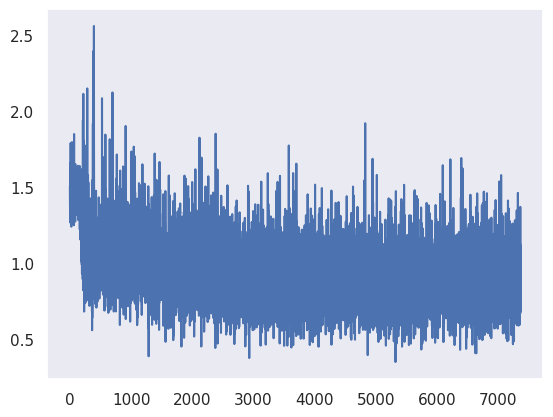

In [52]:
plt.plot(train_losses)

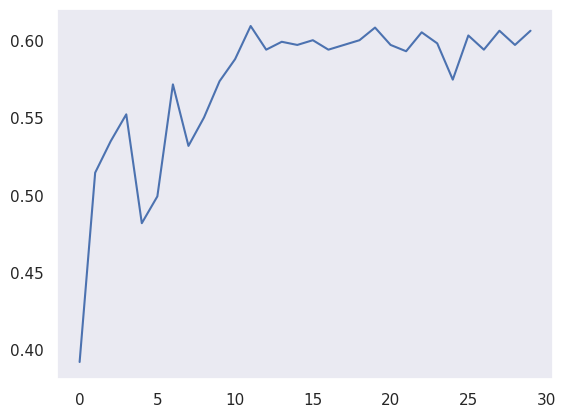

In [53]:
plt.plot(test_accuracy)

In [54]:
metrics2, confusion_matrix2 = report_metrics(
    model, labels=labels, device=device)
pprint(metrics2.compute())
confusion_matrix2.compute()

Correct: 580/976 (0.5943)
{'acc_detail': tensor([0.7391, 0.5438, 0.7087, 0.3770], device='cuda:0'),
 'acc_unweighted': tensor(0.5921, device='cuda:0'),
 'acc_weighted': tensor(0.5943, device='cuda:0'),
 'f1s_detail': tensor([0.7248, 0.4876, 0.6897, 0.4419], device='cuda:0'),
 'f1s_unweighted': tensor(0.5860, device='cuda:0'),
 'f1s_weighted': tensor(0.5899, device='cuda:0'),
 'precision_detail': tensor([0.7110, 0.4419, 0.6716, 0.5337], device='cuda:0'),
 'recall_detail': tensor([0.7391, 0.5438, 0.7087, 0.3770], device='cuda:0'),
 'rocauc': tensor(0.8502, device='cuda:0'),
 'rocauc_detail': tensor([0.9153, 0.8069, 0.8984, 0.7802], device='cuda:0'),
 'uar': tensor(0.5921, device='cuda:0'),
 'wap': tensor(0.5952, device='cuda:0')}


tensor([[187,  15,   2,  49],
        [  3, 118,  66,  30],
        [  8,  62, 180,   4],
        [ 65,  72,  20,  95]], device='cuda:0')

In [55]:
model.to('cpu')
best_model_path = f'{model_path_prefix}{best_epoch}epoch.pt'
print(best_model_path)
best_model = M13(config=model_config,
           n_input=1, n_output=len(labels))
best_model.load_state_dict(torch.load(best_model_path))
best_model.to(device)

metrics_best, confusion_matrix_best = report_metrics(
    best_model, labels=labels, device=device)
best_model.to('cpu')
pprint(metrics_best.compute())
confusion_matrix_best.compute()

../models_cremad4/cremad_label4_m13ser_lognorm_best_12epoch.pt
Correct: 597/976 (0.6117)
{'acc_detail': tensor([0.7549, 0.5668, 0.7008, 0.4167], device='cuda:0'),
 'acc_unweighted': tensor(0.6098, device='cuda:0'),
 'acc_weighted': tensor(0.6117, device='cuda:0'),
 'f1s_detail': tensor([0.7276, 0.5223, 0.6980, 0.4709], device='cuda:0'),
 'f1s_unweighted': tensor(0.6047, device='cuda:0'),
 'f1s_weighted': tensor(0.6080, device='cuda:0'),
 'precision_detail': tensor([0.7022, 0.4843, 0.6953, 0.5412], device='cuda:0'),
 'recall_detail': tensor([0.7549, 0.5668, 0.7008, 0.4167], device='cuda:0'),
 'rocauc': tensor(0.8467, device='cuda:0'),
 'rocauc_detail': tensor([0.9138, 0.8107, 0.8970, 0.7654], device='cuda:0'),
 'uar': tensor(0.6098, device='cuda:0'),
 'wap': tensor(0.6104, device='cuda:0')}


tensor([[191,  14,   1,  47],
        [  4, 123,  58,  32],
        [  6,  60, 178,  10],
        [ 71,  57,  19, 105]], device='cuda:0')

In [56]:
epoch_idx=30
checkpoint_path = f'../models_cremad4/cremad4_m13ser_lognorm_{epoch_idx}epoch.ckpt'
torch.save({
    'epoch': epoch_idx,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': train_losses[-1],
    'best_epoch': best_epoch,
    'best_accuracy': best_accuracy,
    'train_losses': train_losses,
    'test_accuracy': test_accuracy,
    'log_interval': log_interval,
    }, checkpoint_path)

Time domain: Filters' shapes vary by frequency bins


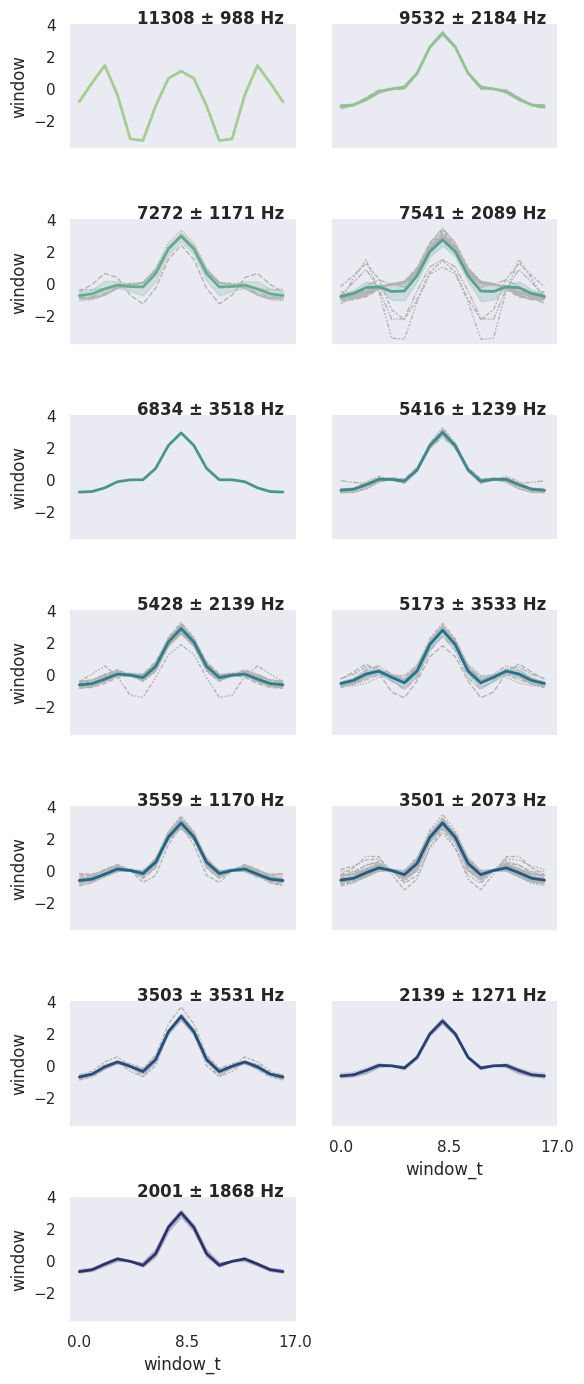

In [57]:
from IConNet.visualizer import visualize_model

layer = best_model.fe_blocks.blocks[0].block.layer

filtviz = visualize_model.FilterVisualizer(
    lowcut_bands = layer.lowcut_bands, 
    bandwidths = layer.bandwidths,
    window_params = layer.window_params, 
    window_length = 64,
    sample_rate = sr
)
filtviz.visualize_filters(filter_domain='time')

Frequency domain: Filters' shapes vary by frequency bins


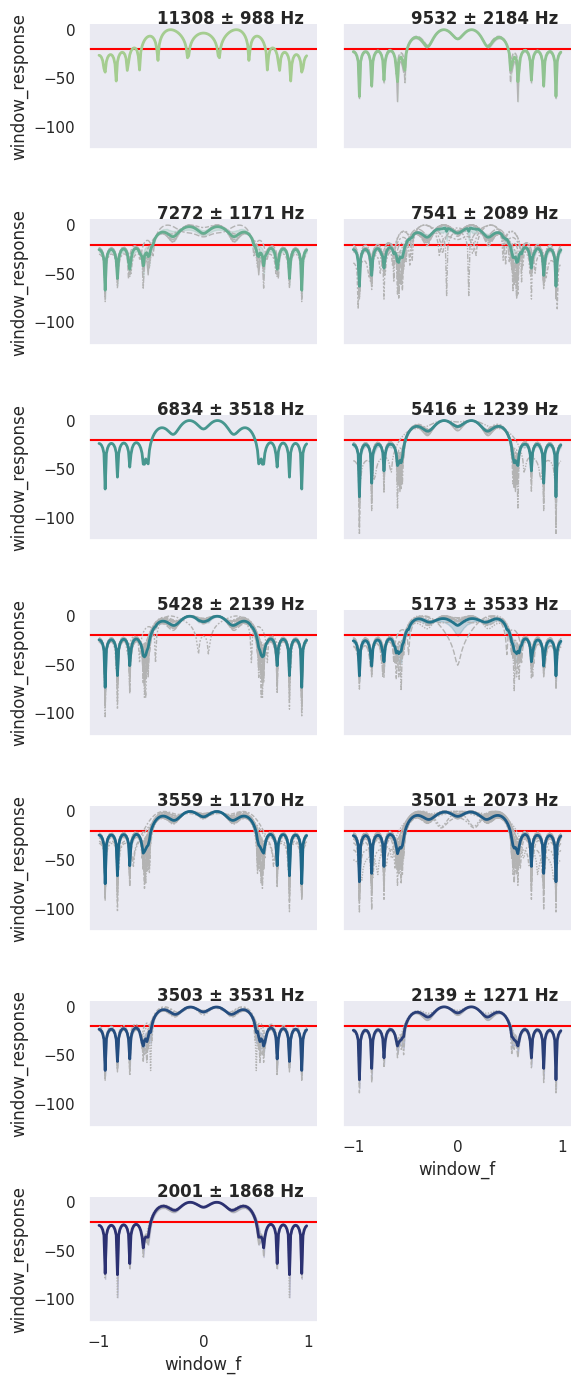

In [59]:
filtviz.visualize_filters(filter_domain='freq')

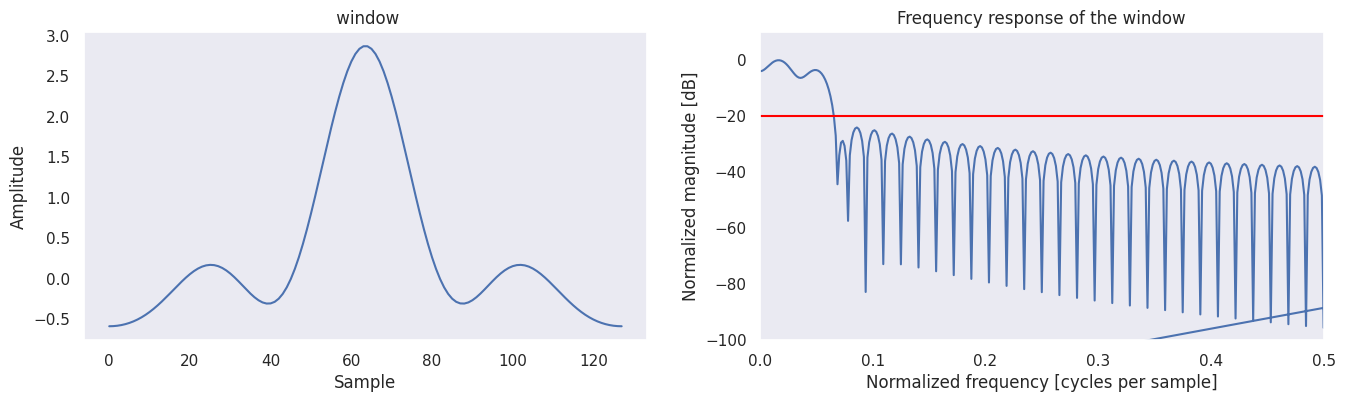

In [60]:
filtviz.visualize_one_window(n_out=10)

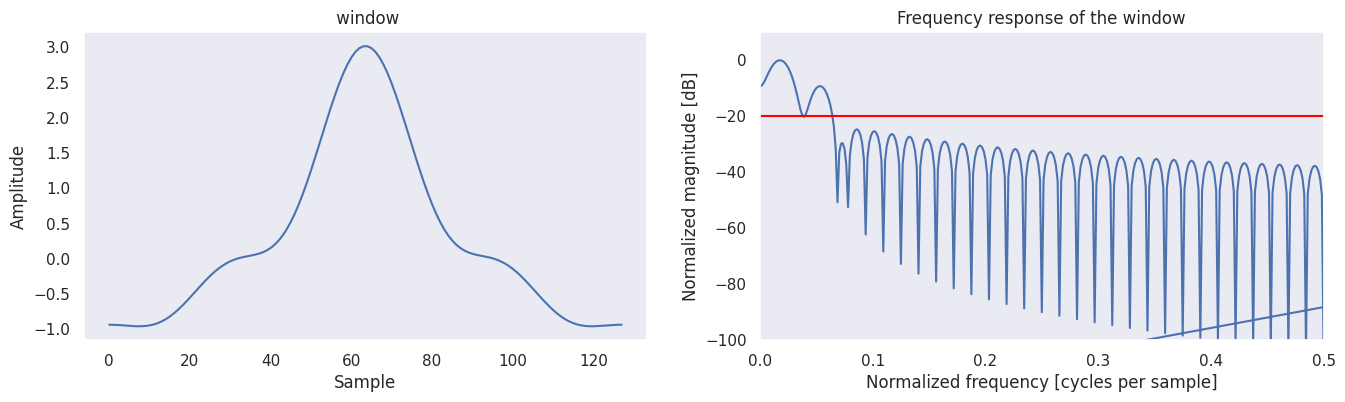

In [61]:
filtviz.visualize_one_window(n_out=30)

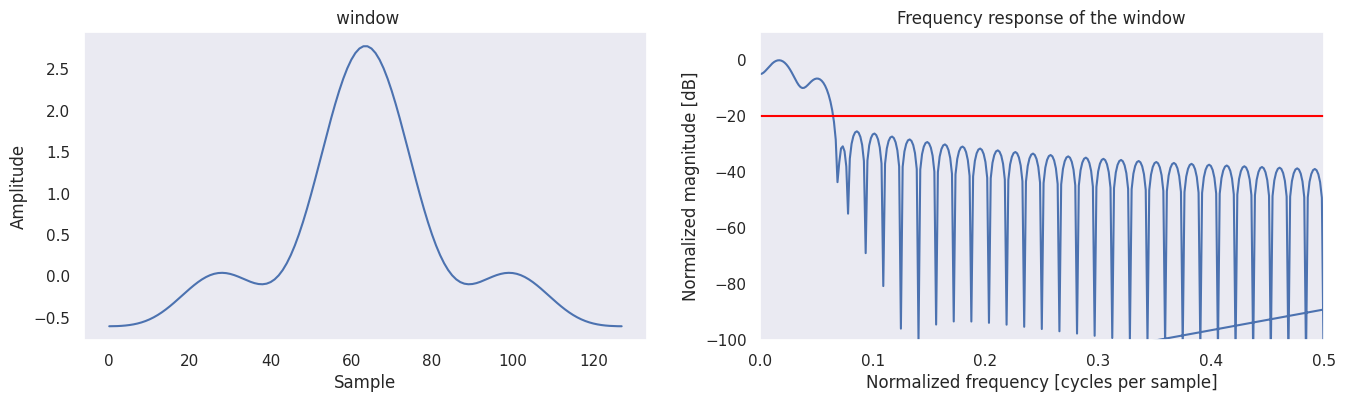

In [62]:
filtviz.visualize_one_window(n_out=50)

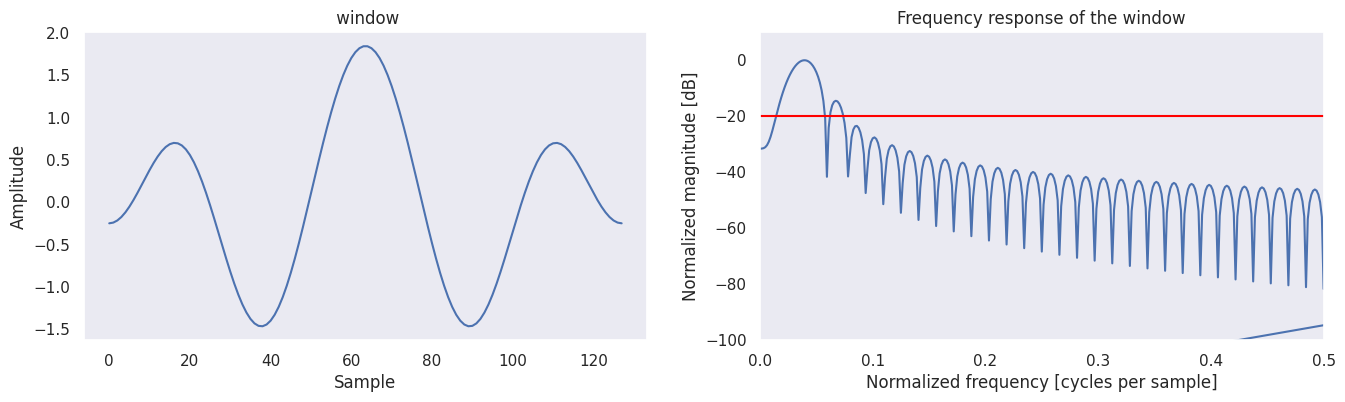

In [63]:
filtviz.visualize_one_window(n_out=60)

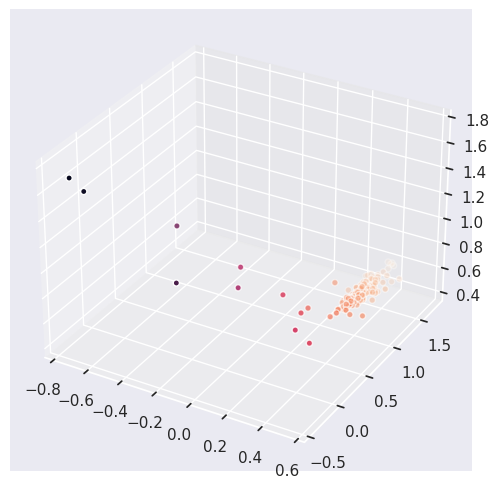

In [64]:
filtviz.visualize_window_params()

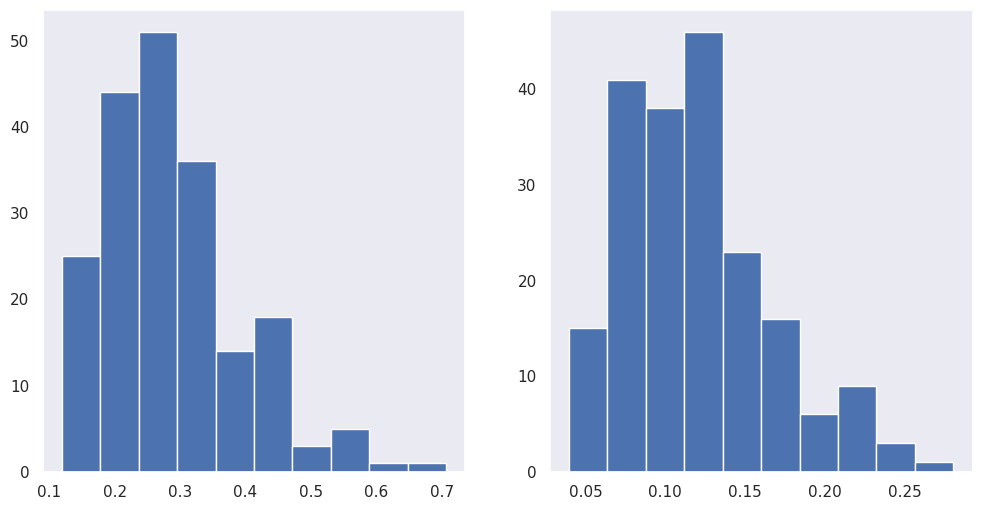

In [65]:
filtviz.visualize_bands()

downsample_factor: 2 => new_sample_rate: 8000
Time domain: Filters' shapes vary by frequency bins


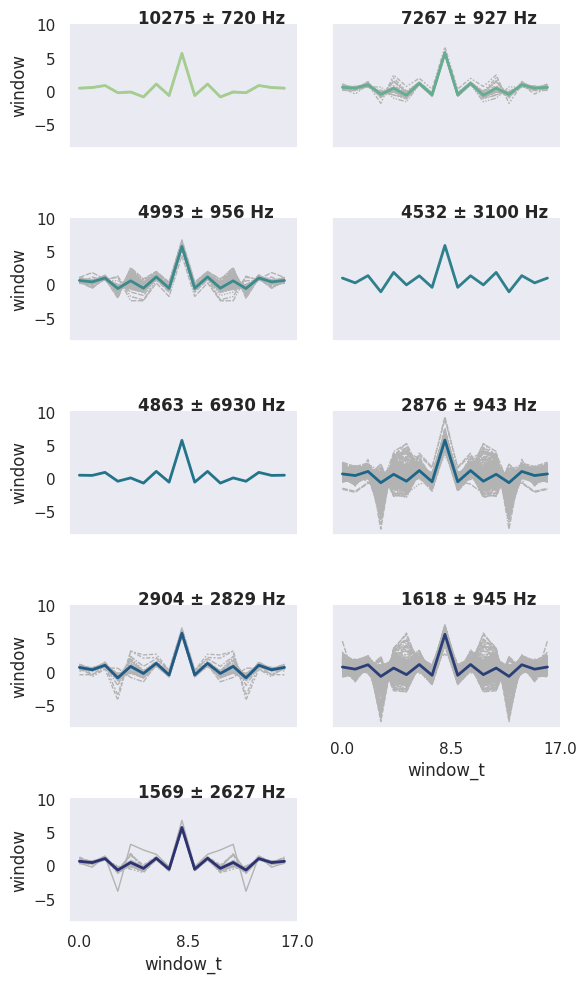

In [66]:
layer2 = best_model.fe_blocks.blocks[1].block.layer
downsample_factor = best_model.fe_blocks.blocks[0].stride
new_sample_rate = sr // downsample_factor
print(f'downsample_factor: {downsample_factor} => new_sample_rate: {new_sample_rate}')

filtviz2 = visualize_model.FilterVisualizer(
    lowcut_bands = layer2.lowcut_bands, 
    bandwidths = layer2.bandwidths,
    window_params = layer2.window_params, 
    window_length = 64,
    sample_rate = new_sample_rate
)
filtviz2.visualize_filters(filter_domain='time')

Frequency domain: Filters' shapes vary by frequency bins


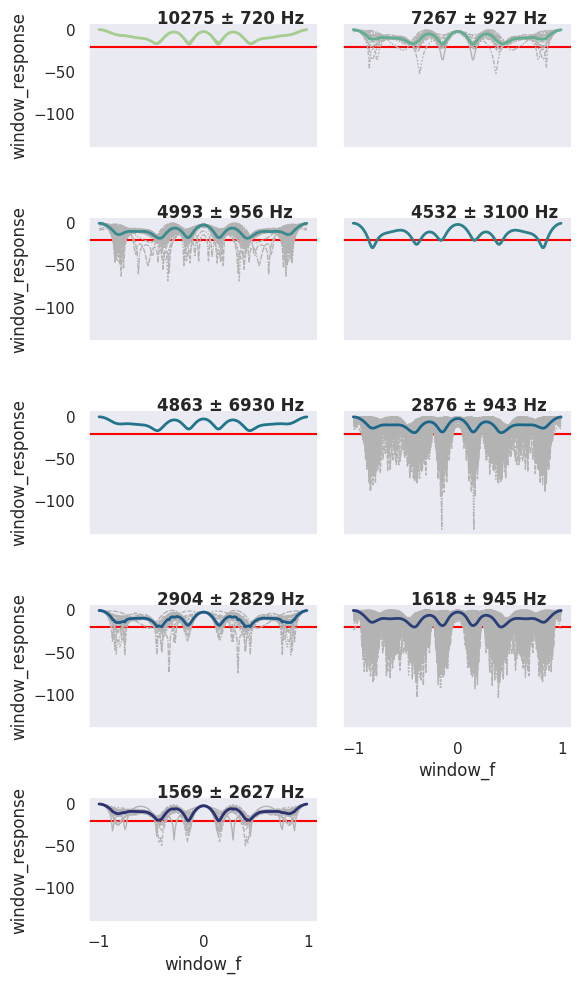

In [67]:
filtviz2.visualize_filters(filter_domain='freq')

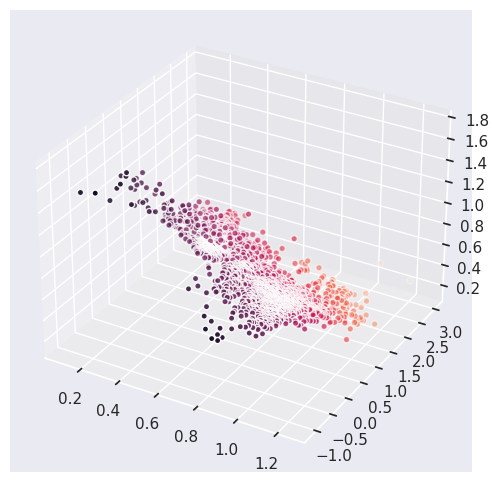

In [68]:
filtviz2.visualize_window_params()

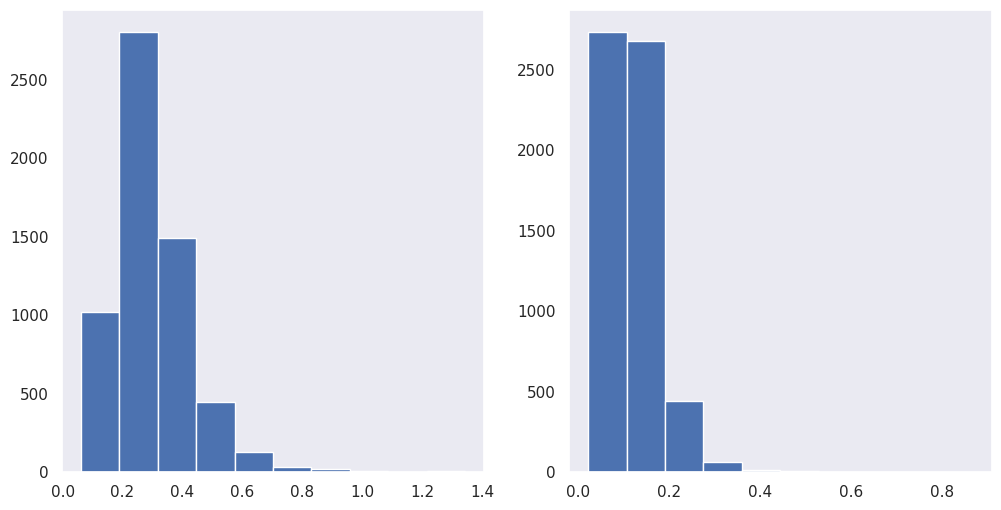

In [69]:
filtviz2.visualize_bands()

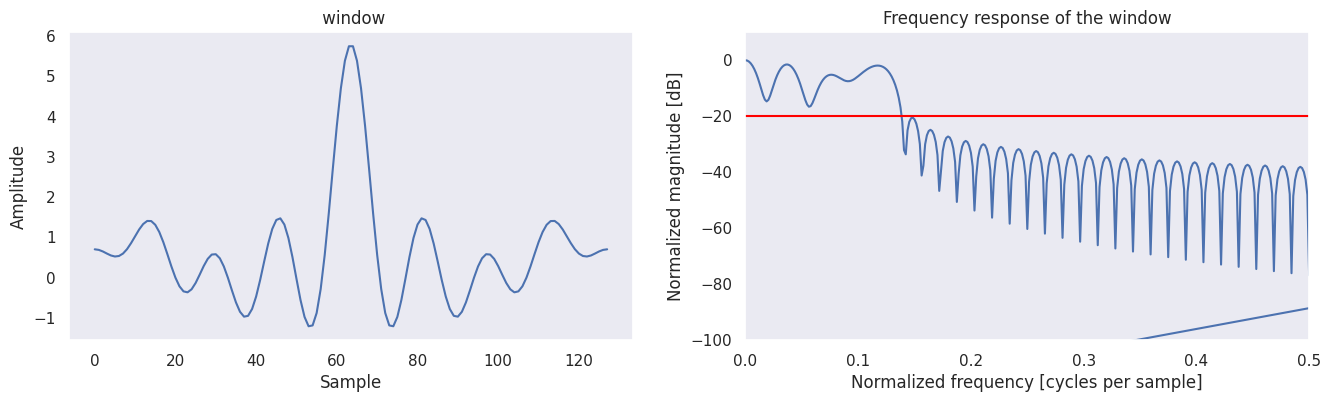

In [70]:
filtviz2.visualize_one_window(n_inp=10, n_out=10)

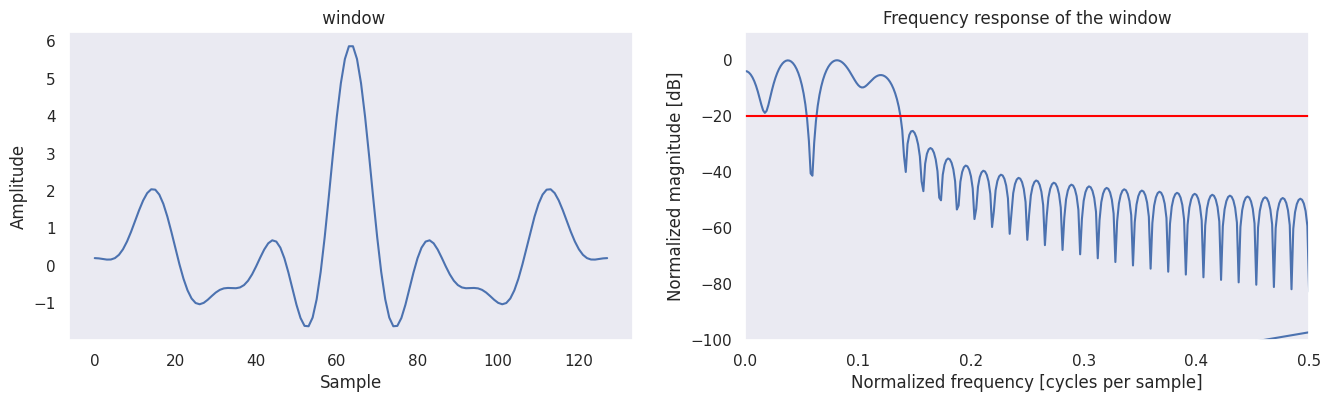

In [71]:
filtviz2.visualize_one_window(n_inp=30, n_out=10)

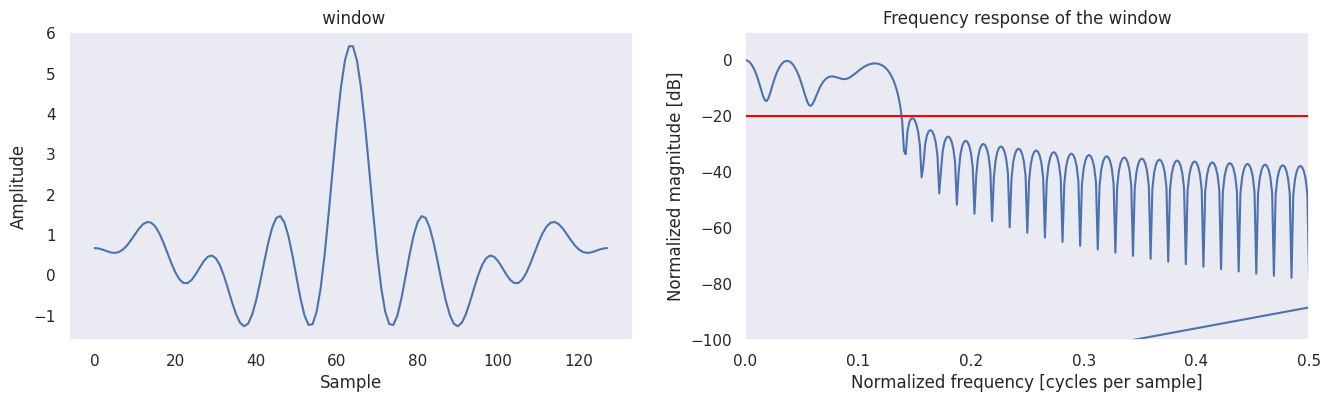

In [72]:
filtviz2.visualize_one_window(n_inp=50, n_out=10)